In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)


In [ ]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, price_type=None)
df.to_pickle('/tmp/df_price_type_none.pkl')
display(df)

In [ ]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, price_type=None, horizon=96)
df.to_pickle('/tmp/df_horizon96_price_type_none.pkl')
display(df)

In [2]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def beta_mean(df, col):
    # broadcast btc value
    idx = df.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(df.loc[idx, col].values, index=df.index)
    
def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = beta_mean(df, 'ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(df, col)
        dfs += [
            # (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    df['ln_volume'] = np.log1p(df['volume'])

    dfs = [df]
    
    # for i in range(1, 96):
    # for i in range(1, 96 // 4):
    for i in range(1, 96 // 8):
    # for i in range(1, 192 // 8):
        dfs += [
            # (df['ln_cl'] - df['ln_cl'].rolling(8 * i).mean()).fillna(0).rename('feature_{:02}_ln_cl_kairi'.format(i)), # good
            # df['ln_cl'].diff(8).shift(i * 8).fillna(0).rename('feature_ln_cl_diff_{:02}'.format(i)),
            df['ln_cl'].diff(8 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)), # good
            # df['ln_cl'].diff(1 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)),
            # df['ln_cl'].diff(4 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)),
            # df['ln_cl'].rolling(8 * i).std().fillna(0).rename('feature_{:02}_ln_cl_std'.format(i)),
            # df['ln_volume'].diff(8 * i).fillna(0).rename('feature_{:02}_ln_volume_diff'.format(i)),
            # df['ln_volume'].rolling(8 * i).mean().fillna(0).rename('feature_{:02}_ln_volume_mean'.format(i)),
            # np.log1p(df['volume'].rolling(8 * i).mean()).fillna(0).rename('feature_{:02}_ln_volume_mean2'.format(i)),
            # signed_rsi_sma(df['cl'], timeperiod=i).fillna(0).rename('feature_{:02}_rsi'.format(i)),
        ]

    return pd.concat(dfs, axis=1)

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Reshape, Conv1D, Conv2D, Conv3D, Flatten, MaxPooling1D, AveragePooling1D,
    BatchNormalization, Concatenate, Activation, Rescaling, Add, Subtract, Lambda,
    GlobalMaxPooling1D, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor
from functools import partial
import tensorflow_addons as tfa

2022-10-19 08:37:50.139382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 08:37:50.365183: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-19 08:37:50.365207: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-19 08:37:50.408382: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-19 08:37:51.144111: W tensorflow/stream_executor/platform/de

In [4]:
from tensorflow.python.ops import gen_math_ops, nn_ops

class GaussianDropConnectDense(Dense):
    def build(self, input_shape):
        super().build(input_shape)
        
        self.kernel_initial = self.kernel.numpy()
        # print(self.kernel_initial)
        
#         self.kernel_old = self.kernel
#         self.bias_old = self.bias
        
        
        
#         self.kernel = self.kernel_old
#         self.bias = self.bias_old * tf.keras.backend.random_normal(
#             shape=tf.shape(self.bias_old),
#             mean=1.0,
#             stddev=sigma,
#             dtype=self.bias_old.dtype,
#             seed=None
#         )
    
    def call(self, inputs, training=None):     
        # dropout_rate = 0.3   
        dropout_rate = 0.5      
        # dropout_rate = 0.7
        sigma = np.sqrt(dropout_rate / (1.0 - dropout_rate))
        
        # kernel = self.kernel_initial + tf.keras.backend.dropout(self.kernel - self.kernel_initial, dropout_rate, seed=None) / (1.0 - dropout_rate)
        kernel = self.kernel_initial + (self.kernel - self.kernel_initial) * tf.keras.backend.random_normal(
            shape=tf.shape(self.kernel),
            mean=1.0,
            stddev=sigma,
            dtype=self.kernel.dtype,
            seed=None
        )
        bias = self.bias
        
        # kernel = self.kernel * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.kernel),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.kernel.dtype,
        #     seed=None
        # )
        # bias = self.bias * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.bias),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.bias.dtype,
        #     seed=None
        # )
        
        kernel = tf.keras.backend.in_train_phase(kernel, self.kernel, training=training)
        bias = tf.keras.backend.in_train_phase(bias, self.bias, training=training)
        
        if inputs.dtype.base_dtype != self._compute_dtype_object.base_dtype:
          inputs = math_ops.cast(inputs, dtype=self._compute_dtype_object)

        rank = inputs.shape.rank
        if rank == 2 or rank is None:
            outputs = gen_math_ops.MatMul(a=inputs, b=kernel)
        # Broadcast kernel to inputs.
        else:
          outputs = standard_ops.tensordot(inputs, kernel, [[rank - 1], [0]])
          # Reshape the output back to the original ndim of the input.
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [kernel.shape[-1]]
            outputs.set_shape(output_shape)

        if self.use_bias:
          outputs = nn_ops.bias_add(outputs, bias)

        if self.activation is not None:
          outputs = self.activation(outputs)
        return outputs

In [5]:
class WeightLenCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.initial_weights = self.model.get_weights()
        self.initial_weights_norm = self._calc_dist(self.initial_weights)
        self.prev_weights = self.initial_weights
        self.weight_len = 0.0

    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        weight_dist = self._calc_dist(self.initial_weights, weights)
        weight_dist2 = self._calc_dist(self.initial_weights, weights, True)
        logs['weight_dist'] = weight_dist
        # logs['weight_dist2'] = weight_dist2
        logs['weight_len'] = self.weight_len
        logs['weight_ndist'] = weight_dist / self.initial_weights_norm
        logs['weight_nlen'] = self.weight_len / self.initial_weights_norm

    def on_train_batch_end(self, batch, logs=None):
        weights = self.model.get_weights()
        self.weight_len += self._calc_dist(self.prev_weights, weights)
        self.prev_weights = weights
        
    def _calc_dist(self, w1, w2=None, normalized=False):
        d = 0.0
        for i in range(len(w1)):
            x = w1[i]
            y = w1[i] if w2 is None else w2[i] 
            if normalized:
                x = x / (1e-37 + np.sum(x ** 2) ** 0.5)
                y = y / (1e-37 + np.sum(y ** 2) ** 0.5)
            if w2 is None:
                d += np.sum(x ** 2)
            else:
                d += np.sum((x - y) ** 2)
        return d ** 0.5

In [6]:
# support multi dimension
class MyVotingRegressor:
    def __init__(self, models):
        self._models = models
        
    def fit(self, X, y, sample_weight=None):
        for label, m in self._models:
            m.fit(X, y, sample_weight=sample_weight)
        return self
        
    def predict(self, X):
        ys = []
        for label, m in self._models:
            ys.append(m.predict(X))
        return np.mean(ys, axis=0)

In [7]:
class LambdaTrain(Lambda):    
    def call(self, inputs, training=None):     
        return tf.keras.backend.in_train_phase(super().call(inputs), inputs, training=training)

In [8]:
import tempfile

class SimpleKerasPredictor:
    def __init__(self, model):
        # self.model = model
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        self.tflite_data = converter.convert()
        
    def predict(self, X):
        if True:
            interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
            signatures = interpreter.get_signature_list()
            # print(signatures)

            input_name = signatures['serving_default']['inputs'][0]
            output_name = signatures['serving_default']['outputs'][0]
            # {'serving_default': {'inputs': ['input_14'], 'outputs': ['activation_13']}}

            sig = interpreter.get_signature_runner()
            # print(sig)
            return sig(**{ input_name: X })[output_name]
        else:
            return self.model.predict(X)
    
    def __getstate__(self):
        state = {}
        state['tflite_data'] = self.tflite_data
        # with tempfile.TemporaryDirectory() as dir:
        #     filename = dir + '/model.h5'
        #     self.model.save(filename, include_optimizer=False)
        #     with open(filename, 'rb') as f:
        #         state['model'] = f.read()
        return state
        
    def __setstate__(self, state):
        self.tflite_data = state['tflite_data']
        # interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
        # self.sig = interpreter.get_signature_runner()

        # with tempfile.TemporaryDirectory() as dir:
        #     model_data = state.get('model')
        #     filename = dir + '/model.h5'
        #     with open(filename, 'wb') as f:
        #         f.write(model_data)
        #     self.model = tf.keras.models.load_model(filename)    

In [9]:

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.linear_model import RidgeCV

class ExampleModelRank:
    def __init__(self, ensemble=10):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        # self._model = lgb.LGBMRegressor(
        #     n_estimators=1000,
        #     learning_rate=0.01,
        #     extra_trees=True,
        #     # colsample_bytree=0.9,
        #     colsample_bytree=0.03,
        #     # lambda_l2=1e1,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        
        # union = FeatureUnion([
        #     ("pt", 'passthrough'),
        #     ("pca", PCA(n_components=32)),
        #     ("svd", TruncatedSVD(n_components=32)),
        #     ("agg", FeatureAgglomeration(n_clusters=32)),
        # ])
        # self._model = Pipeline([
        #     # ('feat_agglo', FeatureAgglomeration(n_clusters=64)),
        #     ('union', union),
        #     ('model', self._model)
        # ])
        
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.price_type = None
        self.ensemble = ensemble

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_mean'] = beta_mean(df, 'ret_train')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        df = df.loc[df.index.get_level_values('symbol') != 'BTC']
        
        print('fit df.shape', df.shape)
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            # verbose=0,
            # mode="auto",
            # min_delta=0.0001,
            # cooldown=0,
            # min_lr=0,
        )
        
        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            # monitor='val_mse_weighted',
            min_delta=0,
            # patience=10,
            patience=40,
            verbose=0,
            mode='auto',
            # mode='max',
            baseline=None,
            restore_best_weights=True
        )
        
        tb = tf.keras.callbacks.TensorBoard(
            log_dir="tb_logs",
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=1,
            embeddings_metadata=None,
        )

        # lr1 = 0.002
        lr1 = 0.002 * 1e-1
        lr0 = lr1 * 1e-2
        def scheduler(epoch, lr):
            if epoch <= 10:
                t = epoch / 10.0
            else:
                t = 1.0
            return np.exp(np.log(lr0) * (1 - t) + np.log(lr1) * t)
        
        # self._model = KerasRegressor(
        #     model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, 0),
        #     # model=partial(build_keras_model, len(features) * 1, 0),
        #     random_state=1,
        #     # random_state=np.random.RandomState(1),
        #     # epochs=1,
        #     # epochs=4,
        #     # epochs=20,
        #     epochs=1000,
        #     validation_split=0.3, # worse than not using val
        #     callbacks=[
        #         es,
        #         # reduce_lr,
        #         # tf.keras.callbacks.LearningRateScheduler(scheduler),
        #         WeightLenCallback(),
        #         # WeightShuffleCallback(),
        #         tb, # last
        #     ],
        #     # batch_size=4096 // 8 // 8,
        #     # batch_size=4096 // 8,
        #     batch_size=4096,
        #     # batch_size=65536,
        #     # batch_size=df.shape[0],
        #     # shuffle=False,
        #     verbose=2,
        #     warm_start=True,
        # )
        # keras_model = self._model
        
        models = []
        for i in range(0, self.ensemble):
            models.append(['nn{}'.format(i), KerasRegressor(
                # model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, i),
                model=partial(build_keras_model, len(features) * 1, i),
                epochs=1000,
                validation_split=0.3, # worse than not using val
                callbacks=[
                    es,
                    # WeightLenCallback(),
                    tb, # last
                ],
                # batch_size=4096 * 8,
                batch_size=4096,
                # batch_size=4096 // 8,
                random_state=i,
                verbose=2 if self.ensemble <= 10 else 0,
            )])
        self._model = MyVotingRegressor(models)
        
        # self._model = BaggingRegressor(self._model, random_state=1)

        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        def scale_func(x):
            return x * 0.1
        
        qt_n = 100
        
        self._model = Pipeline([
            # ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            # ('qt', QuantileTransformer(output_distribution='uniform', random_state=1)),
            # ('sc', StandardScaler(with_mean=False)),
            ('sc', StandardScaler()),
            # ('fu', FeatureUnion([ # not good?
            #     ('pt', 'passthrough'),
            #     ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ('pca', PCA(20, whiten=True)), # good?
            #     # ('fa', FeatureAgglomeration(20, pooling_func=np.median)), # not good?
            #     ('fa_std', Pipeline([ # not bad?
            #         ('fa_std2', FeatureAgglomeration(20, pooling_func=np.std)),
            #         ('qt2', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ])),
            # ])),
            # ('scale', FunctionTransformer(scale_func)),
            # ('pca', PCA(whiten=True)), # bad
            ('model', self._model)
        ])
        
        # self._model = Ridge(alpha=1e5, fit_intercept=False)
        # self._model = RidgeCV(fit_intercept=False)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        sw = np.abs(df['ret_beta'])
        # sw = np.abs(df['ret'])
        sw /= np.mean(sw)
        # sw[:] = 1.0
        # sw += 1e-2
        # sw /= pd.Series(sw).rolling(1000, 1).mean().iloc[::-1].rolling(1000, 1).mean().iloc[::-1].values
        # sw /= np.mean(sw)
        
        X = df[features]
        y = np.sign(df['ret_beta'])
        # y = np.sign(df['ret'])
        # y = (df['ret_beta'] >= 0) * 1.0
        # y = df['ret_beta']
        # y = df['ret_beta'] / df['ret_beta'].std()
        
        # for i in range(20):
        # #     # batch_size = int(32 * 2.0 ** i)
        # #     # batch_size = 32
        #     batch_size = 4096
        #     # batch_size = df.shape[0]
        #     # self._model._random_state = i
        #     self._model.partial_fit(X, y, sample_weight=sw, batch_size=batch_size)
        # #     # self._model.partial_fit(X, y, batch_size=batch_size)
        # #     if es.stopped_epoch > 0:
        #         # break
        
        # self._model.fit(X, y, sample_weight=sw)
        
        for i in range(0):
            # es.patience = 400
            # es.restore_best_weights = True
            # es.monitor = 'loss'
            
            self._model.fit(X, y, model__sample_weight=sw, model__epochs=4)

            weights = keras_model.model_.get_weights()
            for i in range(0, len(weights)):
            # for i in range(len(weights) // 2, len(weights)):
                w = weights[i]
                if False:
                # if len(w.shape) == 1:
                    w[:] = 0.0
                else:
                    # flatten shuffle
                    w = np.random.permutation(w.flatten()).reshape(w.shape)
                    # axis 0 shuffle
                    # w = np.random.permutation(w)
                    # axis 1 shuffle 
                    # maybe overfit
                    # if len(w.shape) == 2:
                    #     w = np.random.permutation(w.T).T
                    # else:
                    #     w = np.random.permutation(w)
                weights[i] = w

            keras_model.model_.set_weights(weights)
        
        es.monitor = 'val_loss'
        # es.monitor = 'val_cosine_similarity'
        # es.patience = 10
        # es.restore_best_weights = True
        self._model.fit(X, y, model__sample_weight=sw)
        
        # converter = tf.lite.TFLiteConverter.from_keras_model(self._model.named_steps['model'].model_)
        # converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # self._model.named_steps['model'].model_ = converter.convert()
        
        # return self._model.fit(df[features], df['ret_beta'])
        # self._model.fit(df[features], np.sign(df['ret_beta']), model__sample_weight=sw)
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
        
        models = self._model.named_steps['model']._models
        for i in range(len(models)):
            models[i][1] = SimpleKerasPredictor(models[i][1].model_)
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features]).flatten()
        
        if os.getenv('USE_JOBLIB_MEMORY'):
            corrs = df[features].corrwith(pd.Series(y_pred, index=df.index))
            plt.plot(corrs.sort_values().values)
            # corrs = df[features].rank().corrwith(pd.Series(y_pred, index=df.index).rank())
            # plt.plot(corrs.sort_values().values)
            plt.show()
        
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        # df['position'] -= 0.5
        idx_btc = df.index.get_level_values('symbol') == 'BTC'
        df.loc[idx_btc, 'position'] = 0
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        df['position_beta'] = df['position'] * df['beta']
        df['position_btc'] = -df.groupby('timestamp')['position_beta'].transform('sum')
        df.loc[idx_btc, 'position'] = df.loc[idx_btc, 'position_btc']
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

class SparseConstraint(tf.keras.constraints.Constraint):
    def __init__(self, mask):
        self.mask = mask
        self.mask_t = tf.convert_to_tensor(mask)

    def __call__(self, w):
        return w * self.mask_t

    def get_config(self):
        return {'mask': self.mask}


# 1dcnn https://www.keep-current.dev/convolution-networks-on-tabular-data/
# tanh, mae: https://github.com/hoseinzadeehsan/CNNpred-Keras
def build_keras_model(input_size, idx=0):
    inputs = Input(shape=(input_size,))
    x = inputs
    # x = Dropout(0.5)(x)
    
    class DistanceL2(tf.keras.regularizers.Regularizer):
        def __init__(self, l2=0.01):
            self.l2 = tf.keras.backend.cast_to_floatx(l2)
            self.initial_x = None
            
        def __call__(self, x):
            initial_x = self.initial_x.flatten()
            diff = tf.reshape(x, (-1,)) - initial_x
            # d = tf.math.reduce_sum(diff * initial_x)
            # n = np.sum(initial_x ** 2)
            # diff = diff - initial_x * d / n
            return 2.0 * self.l2 * tf.nn.l2_loss(diff)

        def get_config(self):
            return {"l2": float(self.l2)}
        
    # l2_dist = 1e-5
    # l2_dist = 1e-4
    # l2_dist = 1e-3
    l2_dist = 0.0
    
    reg_l1 = regularizers.l1(1e-3)
    
    reg = None
    # reg = regularizers.l1(1e-5)
    # reg = regularizers.l2(1e-1)
    # reg = regularizers.l2(1e-2)
    # reg = regularizers.l2(1e-3)
    # reg = regularizers.l2(4e-3)
    # reg = regularizers.l2(1e-4)
    # reg = regularizers.l2(1e-7)
    # reg = regularizers.L1L2(
    #     l1=1e-5, 
    #     l2=1e-5,
    # )
    
    # act = 'relu'
    # act = 'tanh'
    act = 'elu' # good for cnn?
    # act = tf.keras.activations.swish
    # act = tf.keras.layers.LeakyReLU(alpha=0.1)
    # act = tf.keras.layers.PReLU()
    # act = tfa.activations.mish
    # act = 'gelu' # good?
    # act = 'softplus'
    
    # dropout_rate = 0.96
    # dropout_rate = 0.98 # good?
    dropout_rate = 0.99
    # dropout_rate = 0.995
    
    # initializer = initializers.Zeros()
    # initializer = initializers.HeNormal()
    # initializer = initializers.GlorotNormal()
    
    orth_init = initializers.Orthogonal(gain=1.0, seed=None) # bad
    
    # initializer = 'glorot_uniform'
    # initializer = 'glorot_normal'
    initializer = 'he_normal'
    # initializer = 'he_uniform'
    # initializer = orth_init
    bias_initializer = 'zeros'
    # bias_initializer = 'he_normal'
    
#     def initializer(shape, dtype=None):
#         p = 0.1
#         dropout_scale = 1.0 / (0.5 / p + 0.5 * p) ** 0.5 # https://arxiv.org/pdf/1607.02488.pdf
#         # return initializers.GlorotUniform()(shape, dtype=dtype) * 0.1 ** 0.5
#         # return initializers.GlorotNormal()(shape, dtype=dtype) * dropout_scale
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         # w = initializers.Orthogonal(gain=1.0, seed=None)(shape, dtype=dtype)
#         # w = w ** 3 # 3 is good
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         print(shape)
#         n_in, n_out = shape
#         # w /= n_in ** 0.5
#         # w /= n_out ** 0.5 # good
        
#         # https://arxiv.org/pdf/1902.06853.pdf
#         w /= n_in ** 0.5
#         # w *= 1.3
#         # w *= 0.9
#         return w
    
#     def bias_initializer(shape, dtype=None):
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         return w
    
    size = 8
    # size = 12
    # kernel_size = 5
    kernel_size = int(size * 3 / 4)
    # kernel_size = int(size / 2)
    # kernel_size = size
    
    size = 32
    # size = 64
    # size = 128
    # size = 512
    # size = 1024
    
    dist_regs = []
    dist_reg_layers = []
    mars_constraints = []
    
    hidden_outputs = [x]
    
    def conv1d_mean_zero(x):
        return x - tf.math.reduce_mean(x, axis=-1, keepdims=True)
    
    # x = Reshape((23, 2))(x)
    # x = Reshape((11, 4))(x)
    # x = Reshape((95, 2))(x)
    x = Reshape((11, 2))(x)
    # x = Reshape((11, 3))(x)
    # def f1(x):
    #     x = tf.math.cumsum(x, axis=-2)
    #     # x -= tf.math.reduce_mean(x, axis=-2, keepdims=True)
    #     return x
    # x = Lambda(f1)(x)
    # x = Dropout(0.5)(x)
    x = Conv1D(
        filters=32, 
        kernel_size=5,
        # kernel_size=10,
        # kernel_size=5 * 8,
        activation=act, use_bias=True, 
        # padding='SAME',
        padding='VALID',
        kernel_regularizer=reg, 
        bias_regularizer=reg,
        kernel_initializer=initializer, 
        # bias_initializer=initializer,
        # kernel_constraint=conv1d_mean_zero, # good?
    )(x)
    # x = MaxPooling1D(2)(x)
    # x = Dropout(0.5)(x)
    x = Conv1D(
        filters=32,
        kernel_size=5,
        # kernel_size=10,
        # kernel_size=5 * 8,
        activation=act, use_bias=True, 
        # padding='SAME',
        padding='VALID',
        kernel_regularizer=reg, 
        bias_regularizer=reg,
        kernel_initializer=initializer, 
        # bias_initializer=initializer,
        # kernel_constraint=conv1d_mean_zero,
    )(x)
    # x = Dropout(0.5)(x)
    # x = Conv1D(
    #     filters=32, 
    #     kernel_size=4,
    #     activation=act, use_bias=True, 
    #     # padding='SAME',
    #     padding='VALID',
    #     kernel_regularizer=reg, 
    #     bias_regularizer=reg,
    #     kernel_initializer=initializer, 
    #     # bias_initializer=initializer,
    # )(x)
    # x = Dropout(0.5)(x)
    x = MaxPooling1D(2)(x) # good?
    # x = AveragePooling1D(2)(x)
    # x = AveragePooling1D(2)(x)
    # x = AveragePooling1D(2)(x)
    # x = GlobalMaxPooling1D()(x)
    # x = GlobalAveragePooling1D()(x)
    x = Flatten()(x)
    
#     depth = 2 + idx * 0
#     for i in range(depth):
#         t = 1.0 * i / (depth - 1)
#         x_prev = x
        
#         dist_reg = DistanceL2(l2_dist)
#         dist_regs.append(dist_reg)
#         mars_constraint = MarsConstraint(8)
#         mars_constraints.append(mars_constraint)
#         # dense = GaussianDropConnectDense(
#         dense = Dense(
#             # size,
#             # 32,
#             # 64,
#             128, # good with l2 reg
#             # 256,
#             # int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
#             # 64 if i == 0 else 128,
#             activation=act, 
#             # activation=None,
#             use_bias=True,
#             # use_bias=False,
#             # kernel_regularizer=reg_l1, 
#             kernel_regularizer=reg,
#             # kernel_regularizer=dist_reg,
#             # kernel_regularizer=reg2,
#             bias_regularizer=reg,
#             # kernel_initializer='zeros' if i > 0 else initializer,
#             kernel_initializer=initializer, 
#             bias_initializer=bias_initializer,
#             # kernel_constraint=mars_constraint,
#             # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
#         )
#         dist_reg_layers.append(dense)
#         # dense = GaussianDropConnect(dense, rate=0.2)
#         x = dense(x)
#         # x = BatchNormalization()(x)
#         # def smooth_units(x):
#         #     return (x[:, 1:] + x[:, :-1]) / 2
#         #     # return (x[:, 3:] + x[:, 2:-1] + x[:, 1:-2] + x[:, :-3]) / 4
#         # x = Lambda(smooth_units)(x)
#         # x = Activation(act)(x)
#         # x = Lambda(smooth_units)(x)
#         # if i > 0:
#         #     x = Add()([x, x_prev])
#         # if i == 9:
#         #     x = tf.keras.layers.GaussianDropout(0.5)(x)
#         # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
#         # x = Dropout(dropout_rate)(x)
#         # x = Dropout(0.1)(x)
#         # x = tf.keras.layers.GaussianDropout(0.1)(x)
        
#         hidden_outputs.append(x)

        
    # x = Concatenate()(hidden_outputs)
    
    # x = Reshape((-1, 1))(x)
    # x = AveragePooling1D(2)(x)
    # x = Flatten()(x)
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(0.995)(x)
    # x = tf.keras.layers.GaussianDropout(0.9)(x)
    # x = tf.keras.layers.GaussianDropout(1.0 - 0.01 / 2 ** 0.5)(x)
    # x = tf.keras.layers.GaussianNoise(100)(x) # bad

    dist_reg = DistanceL2(l2_dist)
    dist_regs.append(dist_reg)
    # d3 = tfa.layers.NoisyDense(
    # d3 = GaussianDropConnectDense(
    d3 = Dense(
        1,
        # activation='linear',
        # activation='tanh', # good
        # activation='sigmoid',
        # use_factorised=False,
        use_bias=True, 
        # use_bias=False, 
        kernel_regularizer=reg, 
        # kernel_regularizer=dist_reg,
        # kernel_regularizer=reg3, 
        bias_regularizer=reg,
        kernel_initializer=initializer,
        # kernel_initializer='glorot_uniform',
        # kernel_initializer='zeros',
        # bias_initializer=initializer,
    )
    dist_reg_layers.append(d3)
    # d3 = GaussianDropConnect(d3, rate=0.2)
    x = d3(x)
    # x = Rescaling(0.1)(x)
    x = Rescaling(0.01)(x)
    # x = Rescaling(1 - dropout_rate)(x) # good?
    # x = Rescaling(0.04)(x)
    def scale_output_train(x):
        return x * 2.0
    x = LambdaTrain(scale_output_train)(x)
    x = Activation('tanh')(x) # good
    
    model = Model(inputs=inputs, outputs=x)
    
    def make_gc_opt(klass):
        class GCOpt(klass):
            def get_gradients(self, loss, params):
                grads = []
                gradients = super().get_gradients()
                for grad in gradients:
                    grad_len = len(grad.shape)
                    if grad_len > 1:
                        axis = list(range(grad_len - 1))
                        grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
                    grads.append(grad)
                return grads
        return GCOpt
    
    # def _get_gradients(self, tape, loss, var_list, grad_loss=None):
    #     """Called in `minimize` to compute gradients from loss."""
    #     grads = tape.gradient(loss, var_list, grad_loss)
    #     return list(zip(grads, var_list))
    
    def make_gaussian_drop_connect_opt(klass):
        class GaussianDropConnectOpt(klass):
            def _get_gradients(self, tape, loss, var_list, grad_loss=None):
                print('BBB')
                # print(var_list)
                # drop_connect_rate = 0.9
                # sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                # orig_var_list = []
                # for w in var_list:
                #     orig_var_list.append(w)
                #     w.assign(w * tf.keras.backend.random_normal(
                #         shape=tf.shape(w),
                #         mean=1.0,
                #         stddev=sigma,
                #         dtype=w.dtype,
                #         seed=None
                #     ))
                #     # w2 = tf.identity(w2, name=w.name)
                #     # w2 = tf.Variable(w2, name=w.name)
                #     # print(w2)
                #     # var_list2.append(w2)
                grads = tape.gradient(loss, var_list, grad_loss)
                # print(grads)
                return list(zip(grads, var_list))
            
            def get_gradients(self, loss, params):
                print('AAA')
                grads = []
                params2 = []
                drop_connect_rate = 0.9
                sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                for p in params:
                    p = p * tf.keras.backend.random_normal(
                        shape=tf.shape(p),
                        mean=1.0,
                        stddev=sigma,
                        dtype=p.dtype,
                        seed=None
                    )
                    params2.append(p)
                    
                return super().get_gradients(loss, params2)
        return GaussianDropConnectOpt
        
    class AdamWNoise(tfa.optimizers.AdamW):
        def get_gradients(self, loss, params):
            grads = []
            gradients = super().get_gradients()
            for grad in gradients:
                grad += tf.random_normal(
                    shape=grad.get_shape(), 
                    mean=0.0, 
                    stddev=1e-3
                )
                grads.append(grad)
            return grads
    
    # opt = tfa.optimizers.SGDW(
        # weight_decay=1e-4,
    # opt = SGD(
    #     learning_rate=0.01 / 8,
    #     # learning_rate=0.1,
    #     # learning_rate=0.1 / 8,
    #     # learning_rate=1,
    #     momentum=1.0 - 0.1 / 8, 
    #     # nesterov=True,
    # )
    
    # opt = GCNadam(
    opt = Nadam(
        # learning_rate=0.002 * 1e-1,
        learning_rate=0.002,
        beta_1=0.9, 
        # beta_1=0.5,
        # beta_2=0.9,
        beta_2=0.999,
        epsilon=None,
        # epsilon=1e-1,
        # epsilon=1e-3,
        schedule_decay=0.004,
    )
    # opt = tfa.optimizers.AdaBelief(
    #     # learning_rate=0.001,
    #     learning_rate=0.001 / 8,
    #     # learning_rate=0.001 / 8 / 8,
    #     # learning_rate=0.001 / 8 / 8 / 8,
    #     # total_steps=1200,
    #     # warmup_proportion=0.1,
    #     # min_lr=1e-5,
    #     # rectify=True,
    #     # weight_decay=1e-2,
    #     # weight_decay=1e-3,
    #     # epsilon=1e-10,
    # )
    # opt = tfa.optimizers.Lookahead(opt)
    # opt = Adam(
    #     learning_rate=0.001,
    #     beta_1=0.9, 
    #     beta_2=0.999, 
    #     epsilon=None, 
    #     decay=0.0,
    #     # amsgrad=True
    # )
    # opt = AdamWNoise(
    # opt = tfa.optimizers.AdamW(
    # # # opt = make_gaussian_drop_connect_opt(tfa.optimizers.AdamW)(
    #     learning_rate=0.002,
    #     # learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.001 * 1e-1,
    #     # learning_rate=0.002 * 1e-2,
    #     # weight_decay=1e-2,
    #     weight_decay=1e-3,
    #     # weight_decay=1e-4,
    #     # weight_decay=1e-5,
    #     # weight_decay=1e-7,
    #     # beta_1=0.1,
    # )
    
    def my_loss_fn(y_true, y_pred):
        # return tf.reduce_mean(tf.square(tf.sign(y_true) - y_pred) * tf.abs(y_true))
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(y_pred ** 2) ** 0.5) # good
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(tf.abs(y_pred))) # bad
        # ret = tf.reduce_sum(y_pred * y_true, axis=-1)
        # ret /= 1e-37 + tf.reduce_sum(tf.abs(y_pred), axis=-1)
        # return tf.reduce_mean(-ret + ret ** 2)
        
        ret = y_pred * y_true
        sharpe = tf.reduce_mean(ret) / (tf.reduce_mean(ret ** 2) ** 0.5)
        return -sharpe
        # return -sharpe + sharpe ** 2
        
        # p = (y_pred * 0.999 + 1) / 2
        # one_true_p = tf.where(y_true == 1, 0.8, 0.0)
        # zero_true_p = 1.0 - one_true_p
        # return -one_true_p * tf.math.log(p) - zero_true_p * tf.math.log(1 - p)
        # return (y_true - y_pred) ** 2
    
    model.compile(
        optimizer=opt,
        loss='mse', # good for sign ret
        # loss='logcosh', # good for raw ret
        # loss='mae', # good for raw ret
        # loss=my_loss_fn,
        # loss='binary_crossentropy',
        # loss='hinge',
        # loss='squared_hinge',
        # loss='cosine_similarity',
        metrics=[
            'mse',
            # 'accuracy',
        ],
        weighted_metrics=[
            'mse',
            'cosine_similarity',
            # 'logcosh',
            # tfa.metrics.RSquare(),
        ]
    )
    
    for i, dist_reg in enumerate(dist_regs):
        dist_reg.initial_x = dist_reg_layers[i].get_weights()[0]
    for i, mars_constraint in enumerate(mars_constraints):
        mars_constraint.initial_weight = dist_reg_layers[i].get_weights()[0]
    
    # reg_cnn1.initial_x = cnn1.get_weights()[0]
    # reg_cnn2.initial_x = cnn2.get_weights()[0]
    # reg_cnn3.initial_x = cnn3.get_weights()[0]
    # reg1.initial_x = d1.get_weights()[0]
    # reg2.initial_x = d2.get_weights()[0]
    # reg3.initial_x = d3.get_weights()[0]
    
    return model

float32
fit df.shape (195540, 39)


2022-10-19 08:37:55.425902: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-19 08:37:55.425962: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-19 08:37:55.425988: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (540c7ea3ab0a): /proc/driver/nvidia/version does not exist
2022-10-19 08:37:55.426209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/1000
34/34 - 2s - loss: 1.1037 - mse: 1.0081 - weighted_mse: 0.9772 - cosine_similarity: 0.1239 - val_loss: 0.6926 - val_mse: 1.0033 - val_weighted_mse: 0.9924 - val_cosine_similarity: 0.1121 - 2s/epoch - 67ms/step
Epoch 2/1000
34/34 - 1s - loss: 1.0874 - mse: 1.0092 - weighted_mse: 0.9627 - cosine_similarity: 0.1606 - val_loss: 0.6905 - val_mse: 1.0038 - val_weighted_mse: 0.9894 - val_cosine_similarity: 0.1045 - 833ms/epoch - 24ms/step
Epoch 3/1000
34/34 - 2s - loss: 1.0750 - mse: 1.0068 - weighted_mse: 0.9518 - cosine_similarity: 0.1775 - val_loss: 0.6888 - val_mse: 1.0029 - val_weighted_mse: 0.9870 - val_cosine_similarity: 0.0935 - 2s/epoch - 72ms/step
Epoch 4/1000
34/34 - 1s - loss: 1.0660 - mse: 1.0045 - weighted_mse: 0.9438 - cosine_similarity: 0.1916 - val_loss: 0.6883 - val_mse: 1.0038 - val_weighted_mse: 0.9863 - val_cosine_similarity: 0.0897 - 548ms/epoch - 16ms/step
Epoch 5/1000
34/34 - 2s - loss: 1.0597 - mse: 1.0044 - weighted_mse: 0.9382 - cosine_similarity: 0.194

INFO:tensorflow:Assets written to: /tmp/tmpqzz8y0q9/assets


INFO:tensorflow:Assets written to: /tmp/tmpqzz8y0q9/assets
2022-10-19 08:53:52.759447: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 08:53:52.759508: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 08:53:52.760164: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqzz8y0q9
2022-10-19 08:53:52.761880: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 08:53:52.761901: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqzz8y0q9
2022-10-19 08:53:52.767888: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-10-19 08:53:52.769185: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 08:53:52.813125: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

INFO:tensorflow:Assets written to: /tmp/tmpuk4f84wt/assets


INFO:tensorflow:Assets written to: /tmp/tmpuk4f84wt/assets
2022-10-19 08:53:54.017759: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 08:53:54.017805: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 08:53:54.017955: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuk4f84wt
2022-10-19 08:53:54.019415: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 08:53:54.019435: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuk4f84wt
2022-10-19 08:53:54.025784: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 08:53:54.070106: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuk4f84wt
2022-10-19 08:53:54.081442: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6v_4a6oi/assets


INFO:tensorflow:Assets written to: /tmp/tmp6v_4a6oi/assets
2022-10-19 08:53:55.269272: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 08:53:55.269316: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 08:53:55.269440: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6v_4a6oi
2022-10-19 08:53:55.270799: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 08:53:55.270819: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6v_4a6oi
2022-10-19 08:53:55.276704: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 08:53:55.329845: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6v_4a6oi
2022-10-19 08:53:55.341329: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpf9kc0jx4/assets


INFO:tensorflow:Assets written to: /tmp/tmpf9kc0jx4/assets
2022-10-19 08:53:56.523273: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 08:53:56.523314: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 08:53:56.523430: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpf9kc0jx4
2022-10-19 08:53:56.524752: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 08:53:56.524770: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpf9kc0jx4
2022-10-19 08:53:56.530696: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 08:53:56.570200: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpf9kc0jx4
2022-10-19 08:53:56.579592: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzdxs4kf2/assets


INFO:tensorflow:Assets written to: /tmp/tmpzdxs4kf2/assets
2022-10-19 08:53:58.436553: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 08:53:58.436613: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 08:53:58.436759: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzdxs4kf2
2022-10-19 08:53:58.438453: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 08:53:58.438477: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzdxs4kf2
2022-10-19 08:53:58.443605: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 08:53:58.485639: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzdxs4kf2
2022-10-19 08:53:58.494903: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7qiukfb8/assets


INFO:tensorflow:Assets written to: /tmp/tmp7qiukfb8/assets
2022-10-19 08:53:59.705996: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 08:53:59.706055: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 08:53:59.706214: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7qiukfb8
2022-10-19 08:53:59.707687: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 08:53:59.707708: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7qiukfb8
2022-10-19 08:53:59.712801: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 08:53:59.751807: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7qiukfb8
2022-10-19 08:53:59.761237: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1zd4fzpz/assets


INFO:tensorflow:Assets written to: /tmp/tmp1zd4fzpz/assets
2022-10-19 08:54:00.921100: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 08:54:00.921149: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 08:54:00.921299: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1zd4fzpz
2022-10-19 08:54:00.922555: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 08:54:00.922572: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1zd4fzpz
2022-10-19 08:54:00.926659: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 08:54:00.963596: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1zd4fzpz
2022-10-19 08:54:00.973041: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpq5nx747r/assets


INFO:tensorflow:Assets written to: /tmp/tmpq5nx747r/assets
2022-10-19 08:54:02.146255: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 08:54:02.146304: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 08:54:02.146454: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpq5nx747r
2022-10-19 08:54:02.147692: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 08:54:02.147710: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpq5nx747r
2022-10-19 08:54:02.151814: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 08:54:02.188925: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpq5nx747r
2022-10-19 08:54:02.198741: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpksoclej8/assets


INFO:tensorflow:Assets written to: /tmp/tmpksoclej8/assets
2022-10-19 08:54:03.434672: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 08:54:03.434718: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 08:54:03.434863: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpksoclej8
2022-10-19 08:54:03.436122: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 08:54:03.436140: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpksoclej8
2022-10-19 08:54:03.440521: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 08:54:03.477789: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpksoclej8
2022-10-19 08:54:03.487275: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvmwosbw3/assets


INFO:tensorflow:Assets written to: /tmp/tmpvmwosbw3/assets
2022-10-19 08:54:04.734995: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 08:54:04.735048: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 08:54:04.735171: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvmwosbw3
2022-10-19 08:54:04.736517: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 08:54:04.736536: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvmwosbw3
2022-10-19 08:54:04.740624: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 08:54:04.782310: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvmwosbw3
2022-10-19 08:54:04.793657: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

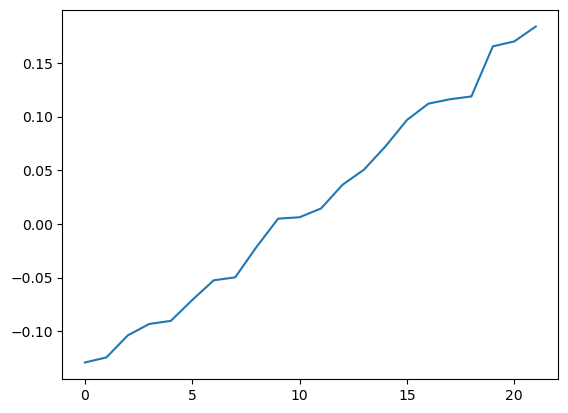

fit df.shape (181853, 39)
Epoch 1/1000
32/32 - 2s - loss: 1.1138 - mse: 1.0089 - weighted_mse: 0.9844 - cosine_similarity: 0.1142 - val_loss: 0.6884 - val_mse: 1.0031 - val_weighted_mse: 0.9930 - val_cosine_similarity: 0.0588 - 2s/epoch - 61ms/step
Epoch 2/1000
32/32 - 2s - loss: 1.1003 - mse: 1.0144 - weighted_mse: 0.9724 - cosine_similarity: 0.1388 - val_loss: 0.6865 - val_mse: 1.0033 - val_weighted_mse: 0.9903 - val_cosine_similarity: 0.0563 - 2s/epoch - 51ms/step
Epoch 3/1000
32/32 - 1s - loss: 1.0901 - mse: 1.0145 - weighted_mse: 0.9634 - cosine_similarity: 0.1562 - val_loss: 0.6852 - val_mse: 1.0041 - val_weighted_mse: 0.9884 - val_cosine_similarity: 0.1183 - 1s/epoch - 46ms/step
Epoch 4/1000
32/32 - 2s - loss: 1.0811 - mse: 1.0137 - weighted_mse: 0.9555 - cosine_similarity: 0.1696 - val_loss: 0.6876 - val_mse: 1.0048 - val_weighted_mse: 0.9919 - val_cosine_similarity: 0.0847 - 2s/epoch - 62ms/step
Epoch 5/1000
32/32 - 1s - loss: 1.0748 - mse: 1.0112 - weighted_mse: 0.9499 - cosi

INFO:tensorflow:Assets written to: /tmp/tmptolpl10g/assets


INFO:tensorflow:Assets written to: /tmp/tmptolpl10g/assets
2022-10-19 09:14:26.369159: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:14:26.369212: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:14:26.369340: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptolpl10g
2022-10-19 09:14:26.370654: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:14:26.370674: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptolpl10g
2022-10-19 09:14:26.375215: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:14:26.415586: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptolpl10g
2022-10-19 09:14:26.426943: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjs9v1jac/assets


INFO:tensorflow:Assets written to: /tmp/tmpjs9v1jac/assets
2022-10-19 09:14:27.591431: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:14:27.591499: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:14:27.591773: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjs9v1jac
2022-10-19 09:14:27.593012: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:14:27.593029: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjs9v1jac
2022-10-19 09:14:27.597202: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:14:27.634283: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjs9v1jac
2022-10-19 09:14:27.643344: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5c8bftat/assets


INFO:tensorflow:Assets written to: /tmp/tmp5c8bftat/assets
2022-10-19 09:14:28.802719: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:14:28.802766: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:14:28.802926: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5c8bftat
2022-10-19 09:14:28.804343: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:14:28.804362: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5c8bftat
2022-10-19 09:14:28.808836: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:14:28.847249: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5c8bftat
2022-10-19 09:14:28.856433: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5ywso0hg/assets


INFO:tensorflow:Assets written to: /tmp/tmp5ywso0hg/assets
2022-10-19 09:14:29.984903: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:14:29.984949: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:14:29.985209: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5ywso0hg
2022-10-19 09:14:29.986450: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:14:29.986467: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5ywso0hg
2022-10-19 09:14:29.990419: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:14:30.027487: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5ywso0hg
2022-10-19 09:14:30.036751: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdx8izawf/assets


INFO:tensorflow:Assets written to: /tmp/tmpdx8izawf/assets
2022-10-19 09:14:31.144335: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:14:31.144385: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:14:31.144503: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdx8izawf
2022-10-19 09:14:31.145843: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:14:31.145861: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdx8izawf
2022-10-19 09:14:31.150044: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:14:31.188076: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdx8izawf
2022-10-19 09:14:31.197703: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2yy5ugsd/assets


INFO:tensorflow:Assets written to: /tmp/tmp2yy5ugsd/assets
2022-10-19 09:14:32.332736: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:14:32.332789: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:14:32.332919: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2yy5ugsd
2022-10-19 09:14:32.334227: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:14:32.334246: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2yy5ugsd
2022-10-19 09:14:32.339862: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:14:32.385647: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2yy5ugsd
2022-10-19 09:14:32.396572: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2m6qm8ww/assets


INFO:tensorflow:Assets written to: /tmp/tmp2m6qm8ww/assets
2022-10-19 09:14:33.823798: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:14:33.823847: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:14:33.823998: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2m6qm8ww
2022-10-19 09:14:33.826625: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:14:33.826671: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2m6qm8ww
2022-10-19 09:14:33.832131: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:14:33.870200: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2m6qm8ww
2022-10-19 09:14:33.879572: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6xpi96e7/assets


INFO:tensorflow:Assets written to: /tmp/tmp6xpi96e7/assets
2022-10-19 09:14:35.081096: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:14:35.081144: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:14:35.081307: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6xpi96e7
2022-10-19 09:14:35.082643: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:14:35.082661: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6xpi96e7
2022-10-19 09:14:35.088232: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:14:35.126192: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6xpi96e7
2022-10-19 09:14:35.135628: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8vf2k5np/assets


INFO:tensorflow:Assets written to: /tmp/tmp8vf2k5np/assets
2022-10-19 09:14:36.266185: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:14:36.266230: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:14:36.266415: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8vf2k5np
2022-10-19 09:14:36.267728: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:14:36.267747: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8vf2k5np
2022-10-19 09:14:36.273475: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:14:36.314045: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8vf2k5np
2022-10-19 09:14:36.324477: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqombk06d/assets


INFO:tensorflow:Assets written to: /tmp/tmpqombk06d/assets
2022-10-19 09:14:38.498182: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:14:38.498240: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:14:38.498418: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqombk06d
2022-10-19 09:14:38.500084: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:14:38.500107: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqombk06d
2022-10-19 09:14:38.505294: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:14:38.550961: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqombk06d
2022-10-19 09:14:38.560882: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

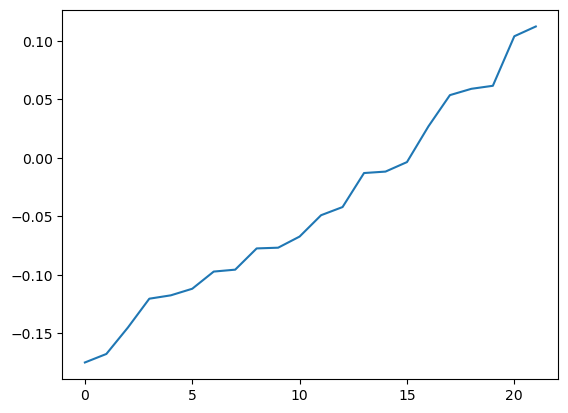

fit df.shape (174593, 39)
Epoch 1/1000
30/30 - 3s - loss: 1.0579 - mse: 1.0023 - weighted_mse: 0.9913 - cosine_similarity: 0.0937 - val_loss: 0.8362 - val_mse: 0.9997 - val_weighted_mse: 0.9916 - val_cosine_similarity: 0.0442 - 3s/epoch - 92ms/step
Epoch 2/1000
30/30 - 1s - loss: 1.0465 - mse: 1.0033 - weighted_mse: 0.9806 - cosine_similarity: 0.1206 - val_loss: 0.8333 - val_mse: 1.0000 - val_weighted_mse: 0.9882 - val_cosine_similarity: 0.0783 - 754ms/epoch - 25ms/step
Epoch 3/1000
30/30 - 1s - loss: 1.0382 - mse: 1.0020 - weighted_mse: 0.9729 - cosine_similarity: 0.1416 - val_loss: 0.8307 - val_mse: 1.0012 - val_weighted_mse: 0.9851 - val_cosine_similarity: 0.1166 - 979ms/epoch - 33ms/step
Epoch 4/1000
30/30 - 2s - loss: 1.0312 - mse: 1.0015 - weighted_mse: 0.9663 - cosine_similarity: 0.1488 - val_loss: 0.8282 - val_mse: 1.0001 - val_weighted_mse: 0.9822 - val_cosine_similarity: 0.1160 - 2s/epoch - 78ms/step
Epoch 5/1000
30/30 - 1s - loss: 1.0250 - mse: 1.0013 - weighted_mse: 0.9605 

INFO:tensorflow:Assets written to: /tmp/tmpm99c5ufc/assets


INFO:tensorflow:Assets written to: /tmp/tmpm99c5ufc/assets
2022-10-19 09:26:45.752335: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:26:45.752385: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:26:45.752503: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm99c5ufc
2022-10-19 09:26:45.753722: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:26:45.753739: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm99c5ufc
2022-10-19 09:26:45.757980: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:26:45.796243: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm99c5ufc
2022-10-19 09:26:45.810322: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_rnclygc/assets


INFO:tensorflow:Assets written to: /tmp/tmp_rnclygc/assets
2022-10-19 09:26:46.957842: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:26:46.957890: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:26:46.958043: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_rnclygc
2022-10-19 09:26:46.959305: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:26:46.959323: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_rnclygc
2022-10-19 09:26:46.963574: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:26:46.999294: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_rnclygc
2022-10-19 09:26:47.008538: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsh5b3op2/assets


INFO:tensorflow:Assets written to: /tmp/tmpsh5b3op2/assets
2022-10-19 09:26:48.143694: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:26:48.143743: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:26:48.143862: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsh5b3op2
2022-10-19 09:26:48.145085: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:26:48.145127: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsh5b3op2
2022-10-19 09:26:48.149217: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:26:48.186515: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsh5b3op2
2022-10-19 09:26:48.197350: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkuabn5ns/assets


INFO:tensorflow:Assets written to: /tmp/tmpkuabn5ns/assets
2022-10-19 09:26:49.318841: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:26:49.318891: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:26:49.319035: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkuabn5ns
2022-10-19 09:26:49.320265: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:26:49.320283: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkuabn5ns
2022-10-19 09:26:49.324466: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:26:49.370119: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkuabn5ns
2022-10-19 09:26:49.380488: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcwfxqdt3/assets


INFO:tensorflow:Assets written to: /tmp/tmpcwfxqdt3/assets
2022-10-19 09:26:50.593214: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:26:50.593265: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:26:50.593412: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcwfxqdt3
2022-10-19 09:26:50.594841: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:26:50.594860: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcwfxqdt3
2022-10-19 09:26:50.599299: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:26:50.637219: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcwfxqdt3
2022-10-19 09:26:50.646613: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpr86kogsp/assets


INFO:tensorflow:Assets written to: /tmp/tmpr86kogsp/assets
2022-10-19 09:26:51.773004: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:26:51.773068: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:26:51.773188: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpr86kogsp
2022-10-19 09:26:51.774398: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:26:51.774456: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpr86kogsp
2022-10-19 09:26:51.778876: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:26:51.815570: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpr86kogsp
2022-10-19 09:26:51.824823: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpve96hwps/assets


INFO:tensorflow:Assets written to: /tmp/tmpve96hwps/assets
2022-10-19 09:26:53.131246: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:26:53.131292: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:26:53.131415: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpve96hwps
2022-10-19 09:26:53.132875: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:26:53.132896: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpve96hwps
2022-10-19 09:26:53.137426: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:26:53.174344: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpve96hwps
2022-10-19 09:26:53.183974: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyj300sqs/assets


INFO:tensorflow:Assets written to: /tmp/tmpyj300sqs/assets
2022-10-19 09:26:54.336350: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:26:54.336398: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:26:54.336521: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyj300sqs
2022-10-19 09:26:54.337868: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:26:54.337886: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyj300sqs
2022-10-19 09:26:54.342201: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:26:54.378685: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyj300sqs
2022-10-19 09:26:54.388062: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6w7lv99a/assets


INFO:tensorflow:Assets written to: /tmp/tmp6w7lv99a/assets
2022-10-19 09:26:55.612275: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:26:55.612324: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:26:55.612447: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6w7lv99a
2022-10-19 09:26:55.613738: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:26:55.613756: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6w7lv99a
2022-10-19 09:26:55.622141: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:26:55.665829: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6w7lv99a
2022-10-19 09:26:55.677017: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2aq6s_pd/assets


INFO:tensorflow:Assets written to: /tmp/tmp2aq6s_pd/assets
2022-10-19 09:26:56.843832: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:26:56.843882: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:26:56.844004: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2aq6s_pd
2022-10-19 09:26:56.845497: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:26:56.845515: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2aq6s_pd
2022-10-19 09:26:56.850793: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:26:56.887260: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2aq6s_pd
2022-10-19 09:26:56.896345: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

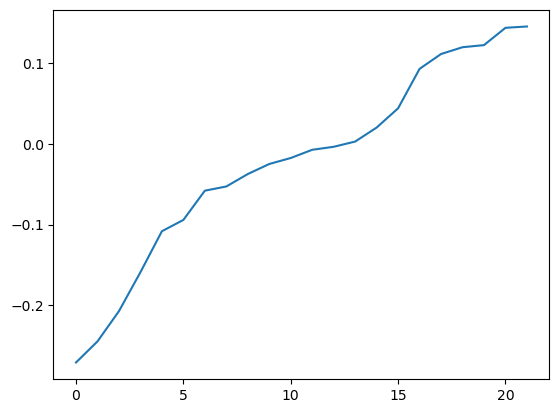

fit df.shape (174593, 39)
Epoch 1/1000
30/30 - 3s - loss: 1.1028 - mse: 1.0053 - weighted_mse: 0.9786 - cosine_similarity: 0.1340 - val_loss: 0.6972 - val_mse: 1.0016 - val_weighted_mse: 0.9904 - val_cosine_similarity: 0.0932 - 3s/epoch - 87ms/step
Epoch 2/1000
30/30 - 1s - loss: 1.0832 - mse: 1.0055 - weighted_mse: 0.9612 - cosine_similarity: 0.1690 - val_loss: 0.6955 - val_mse: 1.0022 - val_weighted_mse: 0.9880 - val_cosine_similarity: 0.1207 - 539ms/epoch - 18ms/step
Epoch 3/1000
30/30 - 2s - loss: 1.0673 - mse: 1.0025 - weighted_mse: 0.9472 - cosine_similarity: 0.1926 - val_loss: 0.6948 - val_mse: 1.0046 - val_weighted_mse: 0.9870 - val_cosine_similarity: 0.1077 - 2s/epoch - 52ms/step
Epoch 4/1000
30/30 - 2s - loss: 1.0554 - mse: 1.0004 - weighted_mse: 0.9365 - cosine_similarity: 0.2076 - val_loss: 0.6931 - val_mse: 1.0053 - val_weighted_mse: 0.9845 - val_cosine_similarity: 0.0930 - 2s/epoch - 82ms/step
Epoch 5/1000
30/30 - 0s - loss: 1.0468 - mse: 1.0009 - weighted_mse: 0.9289 - c

INFO:tensorflow:Assets written to: /tmp/tmpflfre90b/assets


INFO:tensorflow:Assets written to: /tmp/tmpflfre90b/assets
2022-10-19 09:40:10.726667: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:40:10.726741: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:40:10.726869: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpflfre90b
2022-10-19 09:40:10.728192: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:40:10.728212: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpflfre90b
2022-10-19 09:40:10.732595: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:40:10.775075: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpflfre90b
2022-10-19 09:40:10.784534: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnna75afv/assets


INFO:tensorflow:Assets written to: /tmp/tmpnna75afv/assets
2022-10-19 09:40:11.975895: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:40:11.975953: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:40:11.976099: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnna75afv
2022-10-19 09:40:11.977611: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:40:11.977632: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnna75afv
2022-10-19 09:40:11.982500: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:40:12.025352: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnna75afv
2022-10-19 09:40:12.035207: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcboq9q86/assets


INFO:tensorflow:Assets written to: /tmp/tmpcboq9q86/assets
2022-10-19 09:40:13.224576: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:40:13.224627: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:40:13.224778: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcboq9q86
2022-10-19 09:40:13.226026: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:40:13.226044: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcboq9q86
2022-10-19 09:40:13.230209: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:40:13.274953: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcboq9q86
2022-10-19 09:40:13.285451: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgauqc7ml/assets


INFO:tensorflow:Assets written to: /tmp/tmpgauqc7ml/assets
2022-10-19 09:40:14.454000: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:40:14.454067: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:40:14.454300: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgauqc7ml
2022-10-19 09:40:14.455571: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:40:14.455590: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgauqc7ml
2022-10-19 09:40:14.459685: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:40:14.496485: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgauqc7ml
2022-10-19 09:40:14.506130: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7k3rt8d6/assets


INFO:tensorflow:Assets written to: /tmp/tmp7k3rt8d6/assets
2022-10-19 09:40:15.717601: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:40:15.717642: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:40:15.717759: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7k3rt8d6
2022-10-19 09:40:15.719067: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:40:15.719085: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7k3rt8d6
2022-10-19 09:40:15.723385: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:40:15.761236: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7k3rt8d6
2022-10-19 09:40:15.770464: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpu1eo12k7/assets


INFO:tensorflow:Assets written to: /tmp/tmpu1eo12k7/assets
2022-10-19 09:40:16.965417: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:40:16.965463: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:40:16.965582: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpu1eo12k7
2022-10-19 09:40:16.966975: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:40:16.966995: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpu1eo12k7
2022-10-19 09:40:16.971353: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:40:17.009805: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpu1eo12k7
2022-10-19 09:40:17.019050: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd739f975/assets


INFO:tensorflow:Assets written to: /tmp/tmpd739f975/assets
2022-10-19 09:40:18.201241: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:40:18.201291: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:40:18.201414: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd739f975
2022-10-19 09:40:18.202671: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:40:18.202689: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd739f975
2022-10-19 09:40:18.206792: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:40:18.250357: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd739f975
2022-10-19 09:40:18.260109: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp77thw02y/assets


INFO:tensorflow:Assets written to: /tmp/tmp77thw02y/assets
2022-10-19 09:40:19.470622: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:40:19.470670: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:40:19.470791: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp77thw02y
2022-10-19 09:40:19.472072: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:40:19.472104: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp77thw02y
2022-10-19 09:40:19.476673: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:40:19.519355: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp77thw02y
2022-10-19 09:40:19.532892: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpueky8q5l/assets


INFO:tensorflow:Assets written to: /tmp/tmpueky8q5l/assets
2022-10-19 09:40:21.803760: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:40:21.803808: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:40:21.803951: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpueky8q5l
2022-10-19 09:40:21.805153: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:40:21.805170: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpueky8q5l
2022-10-19 09:40:21.809165: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:40:21.846147: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpueky8q5l
2022-10-19 09:40:21.856206: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpovn1a9j3/assets


INFO:tensorflow:Assets written to: /tmp/tmpovn1a9j3/assets
2022-10-19 09:40:24.064202: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:40:24.064312: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:40:24.064437: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpovn1a9j3
2022-10-19 09:40:24.065779: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:40:24.065798: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpovn1a9j3
2022-10-19 09:40:24.070041: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:40:24.106794: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpovn1a9j3
2022-10-19 09:40:24.116032: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

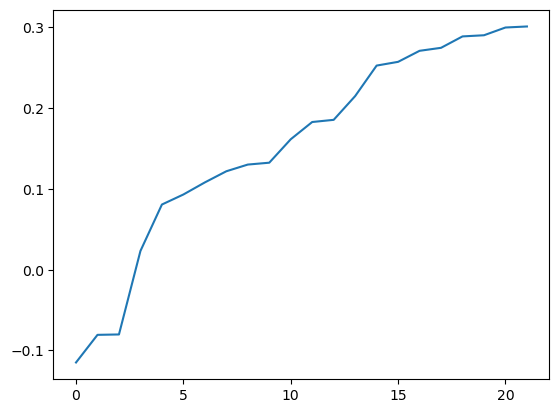

fit df.shape (175043, 39)
Epoch 1/1000
30/30 - 2s - loss: 1.0307 - mse: 1.0050 - weighted_mse: 0.9771 - cosine_similarity: 0.1318 - val_loss: 0.8675 - val_mse: 1.0067 - val_weighted_mse: 0.9947 - val_cosine_similarity: 0.0590 - 2s/epoch - 65ms/step
Epoch 2/1000
30/30 - 1s - loss: 1.0128 - mse: 1.0060 - weighted_mse: 0.9602 - cosine_similarity: 0.1719 - val_loss: 0.8666 - val_mse: 1.0069 - val_weighted_mse: 0.9937 - val_cosine_similarity: 0.0682 - 682ms/epoch - 23ms/step
Epoch 3/1000
30/30 - 1s - loss: 0.9977 - mse: 1.0025 - weighted_mse: 0.9459 - cosine_similarity: 0.1942 - val_loss: 0.8676 - val_mse: 1.0069 - val_weighted_mse: 0.9948 - val_cosine_similarity: 0.0621 - 1s/epoch - 42ms/step
Epoch 4/1000
30/30 - 1s - loss: 0.9864 - mse: 1.0013 - weighted_mse: 0.9352 - cosine_similarity: 0.2094 - val_loss: 0.8672 - val_mse: 1.0096 - val_weighted_mse: 0.9944 - val_cosine_similarity: 0.0895 - 528ms/epoch - 18ms/step
Epoch 5/1000
30/30 - 2s - loss: 0.9794 - mse: 1.0017 - weighted_mse: 0.9285 

INFO:tensorflow:Assets written to: /tmp/tmpqxulzris/assets


INFO:tensorflow:Assets written to: /tmp/tmpqxulzris/assets
2022-10-19 09:56:37.697875: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:56:37.697925: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:56:37.698041: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqxulzris
2022-10-19 09:56:37.699470: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:56:37.699488: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqxulzris
2022-10-19 09:56:37.703599: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:56:37.740568: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqxulzris
2022-10-19 09:56:37.749808: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo91hgq44/assets


INFO:tensorflow:Assets written to: /tmp/tmpo91hgq44/assets
2022-10-19 09:56:38.959331: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:56:38.959396: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:56:38.959558: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo91hgq44
2022-10-19 09:56:38.960819: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:56:38.960837: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo91hgq44
2022-10-19 09:56:38.965086: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:56:39.003732: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo91hgq44
2022-10-19 09:56:39.016218: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpn4ojosw6/assets


INFO:tensorflow:Assets written to: /tmp/tmpn4ojosw6/assets
2022-10-19 09:56:40.204726: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:56:40.204774: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:56:40.204895: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpn4ojosw6
2022-10-19 09:56:40.206214: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:56:40.206357: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpn4ojosw6
2022-10-19 09:56:40.211258: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:56:40.248635: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpn4ojosw6
2022-10-19 09:56:40.258371: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjh81hr1l/assets


INFO:tensorflow:Assets written to: /tmp/tmpjh81hr1l/assets
2022-10-19 09:56:41.467962: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:56:41.468010: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:56:41.468135: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjh81hr1l
2022-10-19 09:56:41.469425: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:56:41.469444: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjh81hr1l
2022-10-19 09:56:41.473532: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:56:41.510702: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjh81hr1l
2022-10-19 09:56:41.519686: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxftvzq9h/assets


INFO:tensorflow:Assets written to: /tmp/tmpxftvzq9h/assets
2022-10-19 09:56:42.699769: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:56:42.699817: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:56:42.699936: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxftvzq9h
2022-10-19 09:56:42.701217: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:56:42.701235: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxftvzq9h
2022-10-19 09:56:42.705426: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:56:42.744224: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxftvzq9h
2022-10-19 09:56:42.753974: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppuxpt6r7/assets


INFO:tensorflow:Assets written to: /tmp/tmppuxpt6r7/assets
2022-10-19 09:56:43.934633: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:56:43.934681: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:56:43.934803: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppuxpt6r7
2022-10-19 09:56:43.936093: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:56:43.936111: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppuxpt6r7
2022-10-19 09:56:43.940230: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:56:43.977067: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppuxpt6r7
2022-10-19 09:56:43.986471: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4ba6hkgg/assets


INFO:tensorflow:Assets written to: /tmp/tmp4ba6hkgg/assets
2022-10-19 09:56:45.303061: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:56:45.303115: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:56:45.303239: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4ba6hkgg
2022-10-19 09:56:45.304496: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:56:45.304514: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4ba6hkgg
2022-10-19 09:56:45.308670: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:56:45.345846: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4ba6hkgg
2022-10-19 09:56:45.355330: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphl91_1ky/assets


INFO:tensorflow:Assets written to: /tmp/tmphl91_1ky/assets
2022-10-19 09:56:46.569850: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:56:46.569904: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:56:46.570035: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphl91_1ky
2022-10-19 09:56:46.571444: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:56:46.571465: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphl91_1ky
2022-10-19 09:56:46.575937: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:56:46.618303: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphl91_1ky
2022-10-19 09:56:46.629767: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_ij1xe42/assets


INFO:tensorflow:Assets written to: /tmp/tmp_ij1xe42/assets
2022-10-19 09:56:47.808005: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:56:47.808057: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:56:47.808204: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_ij1xe42
2022-10-19 09:56:47.809442: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:56:47.809460: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_ij1xe42
2022-10-19 09:56:47.813638: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:56:47.851702: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_ij1xe42
2022-10-19 09:56:47.861251: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwyt7kosu/assets


INFO:tensorflow:Assets written to: /tmp/tmpwyt7kosu/assets
2022-10-19 09:56:49.040117: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 09:56:49.040170: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 09:56:49.040389: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwyt7kosu
2022-10-19 09:56:49.041706: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 09:56:49.041724: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwyt7kosu
2022-10-19 09:56:49.046379: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 09:56:49.088676: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwyt7kosu
2022-10-19 09:56:49.099807: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

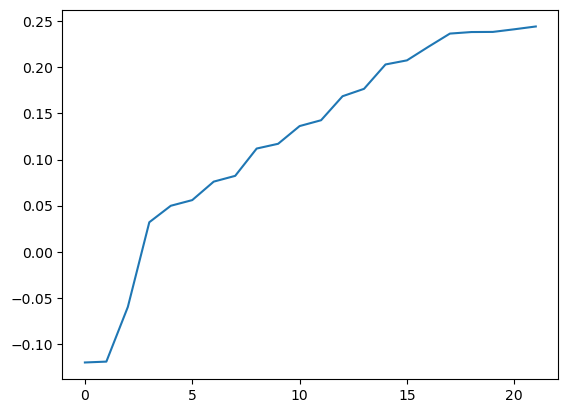

return without cost statistics
mean 0.0036039083232488156
std 0.018540140583646565
sharpe 0.19438408824298037
double sharpe 1.8852089384241701
max drawdown 0.3309082047469022
return with cost statistics
mean 0.0024773429395425627
std 0.01854677504409157
sharpe 0.13357270650305147
double sharpe 1.2477107437078014
max drawdown 0.3310223294926803


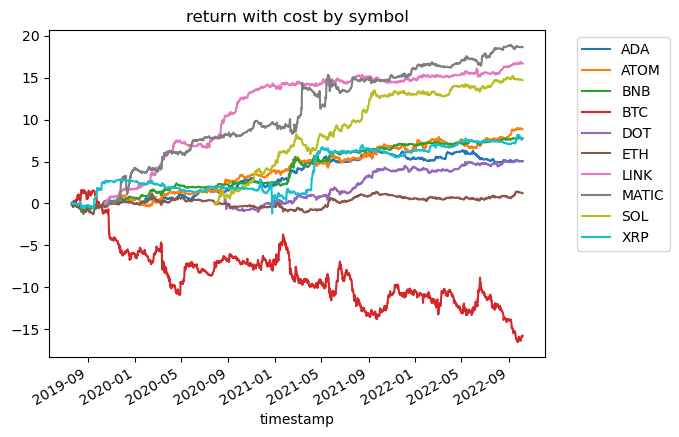

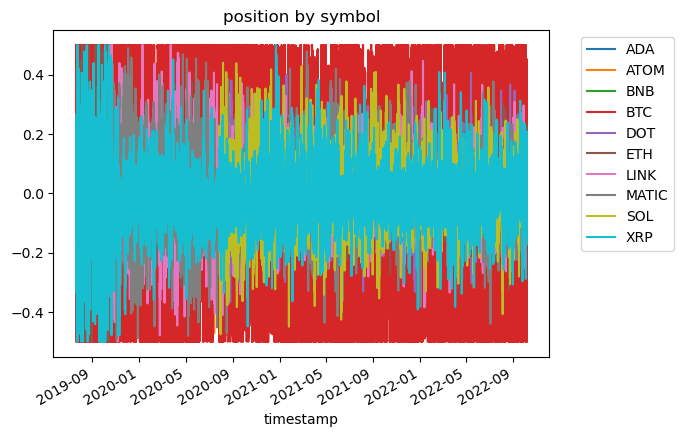

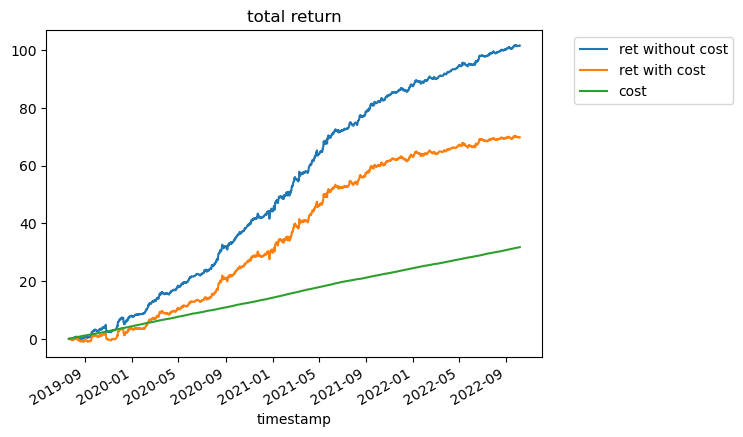

fit df.shape (225839, 39)


INFO:tensorflow:Assets written to: /tmp/tmp56m3voub/assets


INFO:tensorflow:Assets written to: /tmp/tmp56m3voub/assets
2022-10-19 12:40:01.162136: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:01.162203: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:01.162376: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp56m3voub
2022-10-19 12:40:01.163785: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:01.163807: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp56m3voub
2022-10-19 12:40:01.169148: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:01.209367: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp56m3voub
2022-10-19 12:40:01.219268: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp83v3ar0a/assets


INFO:tensorflow:Assets written to: /tmp/tmp83v3ar0a/assets
2022-10-19 12:40:02.396324: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:02.396372: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:02.396492: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp83v3ar0a
2022-10-19 12:40:02.397732: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:02.397751: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp83v3ar0a
2022-10-19 12:40:02.403139: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:02.439965: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp83v3ar0a
2022-10-19 12:40:02.449054: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpiynwgrqt/assets


INFO:tensorflow:Assets written to: /tmp/tmpiynwgrqt/assets
2022-10-19 12:40:03.627651: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:03.627698: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:03.627853: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpiynwgrqt
2022-10-19 12:40:03.629393: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:03.629412: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpiynwgrqt
2022-10-19 12:40:03.633500: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:03.674268: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpiynwgrqt
2022-10-19 12:40:03.684488: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp86k6ym4b/assets


INFO:tensorflow:Assets written to: /tmp/tmp86k6ym4b/assets
2022-10-19 12:40:04.824996: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:04.825043: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:04.825188: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp86k6ym4b
2022-10-19 12:40:04.826460: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:04.826478: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp86k6ym4b
2022-10-19 12:40:04.830526: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:04.873284: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp86k6ym4b
2022-10-19 12:40:04.883116: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3lrgr_cp/assets


INFO:tensorflow:Assets written to: /tmp/tmp3lrgr_cp/assets
2022-10-19 12:40:06.077378: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:06.077424: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:06.077543: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3lrgr_cp
2022-10-19 12:40:06.078798: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:06.078816: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3lrgr_cp
2022-10-19 12:40:06.083171: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:06.119911: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3lrgr_cp
2022-10-19 12:40:06.129066: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjxc0yfm5/assets


INFO:tensorflow:Assets written to: /tmp/tmpjxc0yfm5/assets
2022-10-19 12:40:07.259318: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:07.259372: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:07.259514: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjxc0yfm5
2022-10-19 12:40:07.261031: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:07.261051: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjxc0yfm5
2022-10-19 12:40:07.265801: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:07.304242: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjxc0yfm5
2022-10-19 12:40:07.313611: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_x_ecqsc/assets


INFO:tensorflow:Assets written to: /tmp/tmp_x_ecqsc/assets
2022-10-19 12:40:08.438729: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:08.438778: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:08.438897: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_x_ecqsc
2022-10-19 12:40:08.440203: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:08.440222: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_x_ecqsc
2022-10-19 12:40:08.445540: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:08.484540: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_x_ecqsc
2022-10-19 12:40:08.494247: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwsu84jbt/assets


INFO:tensorflow:Assets written to: /tmp/tmpwsu84jbt/assets
2022-10-19 12:40:09.681343: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:09.681388: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:09.681591: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwsu84jbt
2022-10-19 12:40:09.682879: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:09.682896: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwsu84jbt
2022-10-19 12:40:09.687312: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:09.724387: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwsu84jbt
2022-10-19 12:40:09.733772: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3uataka4/assets


INFO:tensorflow:Assets written to: /tmp/tmp3uataka4/assets
2022-10-19 12:40:10.892295: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:10.892414: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:10.892635: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3uataka4
2022-10-19 12:40:10.893983: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:10.894001: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3uataka4
2022-10-19 12:40:10.898346: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:10.935972: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3uataka4
2022-10-19 12:40:10.945389: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprutcidmq/assets


INFO:tensorflow:Assets written to: /tmp/tmprutcidmq/assets
2022-10-19 12:40:12.064900: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:12.064948: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:12.065095: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprutcidmq
2022-10-19 12:40:12.066455: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:12.066473: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprutcidmq
2022-10-19 12:40:12.070713: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:12.108020: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprutcidmq
2022-10-19 12:40:12.116918: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp47850w0l/assets


INFO:tensorflow:Assets written to: /tmp/tmp47850w0l/assets
2022-10-19 12:40:13.520269: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:13.520316: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:13.520437: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp47850w0l
2022-10-19 12:40:13.521873: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:13.521891: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp47850w0l
2022-10-19 12:40:13.527189: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:13.564733: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp47850w0l
2022-10-19 12:40:13.574106: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmq9onbp5/assets


INFO:tensorflow:Assets written to: /tmp/tmpmq9onbp5/assets
2022-10-19 12:40:16.748058: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:16.748115: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:16.748268: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmq9onbp5
2022-10-19 12:40:16.750938: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:16.750963: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmq9onbp5
2022-10-19 12:40:16.759875: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:16.816659: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmq9onbp5
2022-10-19 12:40:16.830780: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpidl6vav_/assets


INFO:tensorflow:Assets written to: /tmp/tmpidl6vav_/assets
2022-10-19 12:40:18.050593: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:18.050644: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:18.050799: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpidl6vav_
2022-10-19 12:40:18.052247: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:18.052267: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpidl6vav_
2022-10-19 12:40:18.057582: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:18.100372: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpidl6vav_
2022-10-19 12:40:18.110563: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpp_baiqg3/assets


INFO:tensorflow:Assets written to: /tmp/tmpp_baiqg3/assets
2022-10-19 12:40:19.249068: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:19.249115: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:19.249232: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpp_baiqg3
2022-10-19 12:40:19.250701: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:19.250720: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpp_baiqg3
2022-10-19 12:40:19.255678: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:19.295983: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpp_baiqg3
2022-10-19 12:40:19.306113: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6zwv3_nl/assets


INFO:tensorflow:Assets written to: /tmp/tmp6zwv3_nl/assets
2022-10-19 12:40:20.478413: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:20.478463: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:20.478666: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6zwv3_nl
2022-10-19 12:40:20.479956: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:20.479975: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6zwv3_nl
2022-10-19 12:40:20.484376: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:20.525284: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6zwv3_nl
2022-10-19 12:40:20.536252: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6_w6rzyw/assets


INFO:tensorflow:Assets written to: /tmp/tmp6_w6rzyw/assets
2022-10-19 12:40:21.738614: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:21.738653: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:21.738773: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6_w6rzyw
2022-10-19 12:40:21.740045: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:21.740064: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6_w6rzyw
2022-10-19 12:40:21.744452: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:21.786201: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6_w6rzyw
2022-10-19 12:40:21.796394: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpj13p7mtf/assets


INFO:tensorflow:Assets written to: /tmp/tmpj13p7mtf/assets
2022-10-19 12:40:23.008921: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:23.008978: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:23.009129: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpj13p7mtf
2022-10-19 12:40:23.010685: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:23.010708: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpj13p7mtf
2022-10-19 12:40:23.015630: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:23.055802: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpj13p7mtf
2022-10-19 12:40:23.064837: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_gbxe_7q/assets


INFO:tensorflow:Assets written to: /tmp/tmp_gbxe_7q/assets
2022-10-19 12:40:24.202072: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:24.202162: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:24.202281: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_gbxe_7q
2022-10-19 12:40:24.203504: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:24.203522: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_gbxe_7q
2022-10-19 12:40:24.207737: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:24.245299: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_gbxe_7q
2022-10-19 12:40:24.255262: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2j0i5m2h/assets


INFO:tensorflow:Assets written to: /tmp/tmp2j0i5m2h/assets
2022-10-19 12:40:25.422213: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:25.422256: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:25.422374: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2j0i5m2h
2022-10-19 12:40:25.423580: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:25.423597: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2j0i5m2h
2022-10-19 12:40:25.427904: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:25.466822: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2j0i5m2h
2022-10-19 12:40:25.476356: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpoo8esujb/assets


INFO:tensorflow:Assets written to: /tmp/tmpoo8esujb/assets
2022-10-19 12:40:26.588971: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:26.589016: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:26.589242: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpoo8esujb
2022-10-19 12:40:26.590490: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:26.590508: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpoo8esujb
2022-10-19 12:40:26.594645: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:26.632928: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpoo8esujb
2022-10-19 12:40:26.642584: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpv_sb528h/assets


INFO:tensorflow:Assets written to: /tmp/tmpv_sb528h/assets
2022-10-19 12:40:27.787827: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:27.787874: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:27.787994: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpv_sb528h
2022-10-19 12:40:27.789368: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:27.789387: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpv_sb528h
2022-10-19 12:40:27.793716: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:27.832643: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpv_sb528h
2022-10-19 12:40:27.842007: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb4qob29q/assets


INFO:tensorflow:Assets written to: /tmp/tmpb4qob29q/assets
2022-10-19 12:40:28.972037: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:28.972083: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:28.972218: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb4qob29q
2022-10-19 12:40:28.973479: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:28.973498: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb4qob29q
2022-10-19 12:40:28.977944: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:29.017345: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb4qob29q
2022-10-19 12:40:29.027079: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt8mrp7bu/assets


INFO:tensorflow:Assets written to: /tmp/tmpt8mrp7bu/assets
2022-10-19 12:40:30.173510: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:30.173563: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:30.173698: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt8mrp7bu
2022-10-19 12:40:30.175117: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:30.175137: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt8mrp7bu
2022-10-19 12:40:30.179336: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:30.215154: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt8mrp7bu
2022-10-19 12:40:30.224096: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5h7sf0yk/assets


INFO:tensorflow:Assets written to: /tmp/tmp5h7sf0yk/assets
2022-10-19 12:40:31.436918: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:31.436994: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:31.437158: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5h7sf0yk
2022-10-19 12:40:31.439101: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:31.439151: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5h7sf0yk
2022-10-19 12:40:31.443760: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:31.486220: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5h7sf0yk
2022-10-19 12:40:31.497137: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6exg7h1l/assets


INFO:tensorflow:Assets written to: /tmp/tmp6exg7h1l/assets
2022-10-19 12:40:34.536825: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:34.536888: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:34.537059: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6exg7h1l
2022-10-19 12:40:34.541131: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:34.541158: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6exg7h1l
2022-10-19 12:40:34.560378: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:34.665371: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6exg7h1l
2022-10-19 12:40:34.696945: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0abuoxss/assets


INFO:tensorflow:Assets written to: /tmp/tmp0abuoxss/assets
2022-10-19 12:40:36.313323: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:36.313382: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:36.313537: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0abuoxss
2022-10-19 12:40:36.316159: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:36.316185: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0abuoxss
2022-10-19 12:40:36.324352: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:36.380823: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0abuoxss
2022-10-19 12:40:36.395723: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpin1u2grc/assets


INFO:tensorflow:Assets written to: /tmp/tmpin1u2grc/assets
2022-10-19 12:40:37.627669: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:37.627725: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:37.627894: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpin1u2grc
2022-10-19 12:40:37.629558: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:37.629580: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpin1u2grc
2022-10-19 12:40:37.635204: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:37.679107: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpin1u2grc
2022-10-19 12:40:37.689719: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpiszamap4/assets


INFO:tensorflow:Assets written to: /tmp/tmpiszamap4/assets
2022-10-19 12:40:38.870544: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:38.870592: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:38.870713: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpiszamap4
2022-10-19 12:40:38.872009: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:38.872028: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpiszamap4
2022-10-19 12:40:38.876461: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:38.914286: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpiszamap4
2022-10-19 12:40:38.923825: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnbs98i4n/assets


INFO:tensorflow:Assets written to: /tmp/tmpnbs98i4n/assets
2022-10-19 12:40:40.089523: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:40.089572: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:40.089696: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnbs98i4n
2022-10-19 12:40:40.091119: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:40.091136: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnbs98i4n
2022-10-19 12:40:40.095497: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:40.134460: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnbs98i4n
2022-10-19 12:40:40.145202: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2pxdojoz/assets


INFO:tensorflow:Assets written to: /tmp/tmp2pxdojoz/assets
2022-10-19 12:40:41.288890: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:41.288937: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:41.289085: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2pxdojoz
2022-10-19 12:40:41.290314: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:41.290332: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2pxdojoz
2022-10-19 12:40:41.294528: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:41.334603: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2pxdojoz
2022-10-19 12:40:41.344553: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvdi_eel7/assets


INFO:tensorflow:Assets written to: /tmp/tmpvdi_eel7/assets
2022-10-19 12:40:42.489869: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:42.489916: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:42.490035: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvdi_eel7
2022-10-19 12:40:42.491306: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:42.491324: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvdi_eel7
2022-10-19 12:40:42.495434: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:42.533751: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvdi_eel7
2022-10-19 12:40:42.544199: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9o1cm8_b/assets


INFO:tensorflow:Assets written to: /tmp/tmp9o1cm8_b/assets
2022-10-19 12:40:43.695288: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:43.695334: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:43.695454: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9o1cm8_b
2022-10-19 12:40:43.696868: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:43.696885: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9o1cm8_b
2022-10-19 12:40:43.701187: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:43.739650: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9o1cm8_b
2022-10-19 12:40:43.749312: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp987av6c9/assets


INFO:tensorflow:Assets written to: /tmp/tmp987av6c9/assets
2022-10-19 12:40:44.890202: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:44.890293: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:44.890411: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp987av6c9
2022-10-19 12:40:44.891681: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:44.891698: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp987av6c9
2022-10-19 12:40:44.896556: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:44.941069: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp987av6c9
2022-10-19 12:40:44.950496: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpklg_yvmi/assets


INFO:tensorflow:Assets written to: /tmp/tmpklg_yvmi/assets
2022-10-19 12:40:46.103565: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:46.103614: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:46.103740: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpklg_yvmi
2022-10-19 12:40:46.105093: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:46.105112: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpklg_yvmi
2022-10-19 12:40:46.110404: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:46.150432: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpklg_yvmi
2022-10-19 12:40:46.159574: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplopytkz1/assets


INFO:tensorflow:Assets written to: /tmp/tmplopytkz1/assets
2022-10-19 12:40:47.298760: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:47.298809: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:47.299016: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplopytkz1
2022-10-19 12:40:47.300342: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:47.300362: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplopytkz1
2022-10-19 12:40:47.304600: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:47.342645: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplopytkz1
2022-10-19 12:40:47.351683: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpq04caezl/assets


INFO:tensorflow:Assets written to: /tmp/tmpq04caezl/assets
2022-10-19 12:40:50.377630: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:50.377689: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:50.377844: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpq04caezl
2022-10-19 12:40:50.380747: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:50.380773: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpq04caezl
2022-10-19 12:40:50.392392: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:50.470602: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpq04caezl
2022-10-19 12:40:50.493167: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp14xvc84a/assets


INFO:tensorflow:Assets written to: /tmp/tmp14xvc84a/assets
2022-10-19 12:40:51.868204: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:51.868270: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:51.868461: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp14xvc84a
2022-10-19 12:40:51.870552: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:51.870576: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp14xvc84a
2022-10-19 12:40:51.876996: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:51.925134: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp14xvc84a
2022-10-19 12:40:51.935610: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4c09olf9/assets


INFO:tensorflow:Assets written to: /tmp/tmp4c09olf9/assets
2022-10-19 12:40:53.157737: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:53.157779: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:53.157898: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4c09olf9
2022-10-19 12:40:53.159534: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:53.159554: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4c09olf9
2022-10-19 12:40:53.165211: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:53.208583: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4c09olf9
2022-10-19 12:40:53.219238: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp24u5j8cw/assets


INFO:tensorflow:Assets written to: /tmp/tmp24u5j8cw/assets
2022-10-19 12:40:54.390614: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:54.390662: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:54.390813: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp24u5j8cw
2022-10-19 12:40:54.392960: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:54.392986: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp24u5j8cw
2022-10-19 12:40:54.399660: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:54.450546: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp24u5j8cw
2022-10-19 12:40:54.462212: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppfz6klns/assets


INFO:tensorflow:Assets written to: /tmp/tmppfz6klns/assets
2022-10-19 12:40:55.617913: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:55.617952: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:55.618070: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppfz6klns
2022-10-19 12:40:55.619332: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:55.619351: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppfz6klns
2022-10-19 12:40:55.623795: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:55.662815: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppfz6klns
2022-10-19 12:40:55.672264: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3gfmg99m/assets


INFO:tensorflow:Assets written to: /tmp/tmp3gfmg99m/assets
2022-10-19 12:40:56.823204: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:56.823241: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:56.823355: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3gfmg99m
2022-10-19 12:40:56.824650: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:56.824668: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3gfmg99m
2022-10-19 12:40:56.828916: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:56.869111: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3gfmg99m
2022-10-19 12:40:56.879685: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppjuzk4ge/assets


INFO:tensorflow:Assets written to: /tmp/tmppjuzk4ge/assets
2022-10-19 12:40:58.035815: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:58.035864: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:58.035990: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppjuzk4ge
2022-10-19 12:40:58.037343: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:58.037362: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppjuzk4ge
2022-10-19 12:40:58.041974: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:58.081004: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppjuzk4ge
2022-10-19 12:40:58.090345: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5r0yr438/assets


INFO:tensorflow:Assets written to: /tmp/tmp5r0yr438/assets
2022-10-19 12:40:59.245359: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:40:59.245407: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:40:59.245604: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5r0yr438
2022-10-19 12:40:59.246877: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:40:59.246895: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5r0yr438
2022-10-19 12:40:59.251067: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:40:59.290847: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5r0yr438
2022-10-19 12:40:59.300404: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprtfi0ij7/assets


INFO:tensorflow:Assets written to: /tmp/tmprtfi0ij7/assets
2022-10-19 12:41:00.483999: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:00.484040: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:00.484161: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprtfi0ij7
2022-10-19 12:41:00.485473: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:00.485493: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprtfi0ij7
2022-10-19 12:41:00.489851: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:00.529363: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprtfi0ij7
2022-10-19 12:41:00.539245: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpha8__hey/assets


INFO:tensorflow:Assets written to: /tmp/tmpha8__hey/assets
2022-10-19 12:41:03.149488: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:03.149548: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:03.149708: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpha8__hey
2022-10-19 12:41:03.154004: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:03.154028: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpha8__hey
2022-10-19 12:41:03.174084: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:03.295731: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpha8__hey
2022-10-19 12:41:03.328142: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2xl3ogg9/assets


INFO:tensorflow:Assets written to: /tmp/tmp2xl3ogg9/assets
2022-10-19 12:41:05.036500: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:05.036576: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:05.036743: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2xl3ogg9
2022-10-19 12:41:05.040585: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:05.040617: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2xl3ogg9
2022-10-19 12:41:05.053407: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:05.114880: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2xl3ogg9
2022-10-19 12:41:05.131163: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5c5eri0s/assets


INFO:tensorflow:Assets written to: /tmp/tmp5c5eri0s/assets
2022-10-19 12:41:06.443370: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:06.443436: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:06.443603: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5c5eri0s
2022-10-19 12:41:06.445658: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:06.445683: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5c5eri0s
2022-10-19 12:41:06.452426: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:06.502461: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5c5eri0s
2022-10-19 12:41:06.513808: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpg0pwdgs6/assets


INFO:tensorflow:Assets written to: /tmp/tmpg0pwdgs6/assets
2022-10-19 12:41:07.704021: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:07.704068: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:07.704188: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpg0pwdgs6
2022-10-19 12:41:07.705623: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:07.705642: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpg0pwdgs6
2022-10-19 12:41:07.710608: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:07.753259: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpg0pwdgs6
2022-10-19 12:41:07.766188: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcmzmbgob/assets


INFO:tensorflow:Assets written to: /tmp/tmpcmzmbgob/assets
2022-10-19 12:41:08.949683: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:08.949736: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:08.949861: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcmzmbgob
2022-10-19 12:41:08.951256: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:08.951275: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcmzmbgob
2022-10-19 12:41:08.956154: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:09.000314: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcmzmbgob
2022-10-19 12:41:09.015685: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpj6f3in_j/assets


INFO:tensorflow:Assets written to: /tmp/tmpj6f3in_j/assets
2022-10-19 12:41:10.161006: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:10.161053: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:10.161199: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpj6f3in_j
2022-10-19 12:41:10.162549: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:10.162568: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpj6f3in_j
2022-10-19 12:41:10.167124: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:10.211451: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpj6f3in_j
2022-10-19 12:41:10.222260: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4lxj6e38/assets


INFO:tensorflow:Assets written to: /tmp/tmp4lxj6e38/assets
2022-10-19 12:41:11.390016: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:11.390062: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:11.390271: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4lxj6e38
2022-10-19 12:41:11.391608: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:11.391662: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4lxj6e38
2022-10-19 12:41:11.396385: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:11.435945: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4lxj6e38
2022-10-19 12:41:11.445906: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp354747x3/assets


INFO:tensorflow:Assets written to: /tmp/tmp354747x3/assets
2022-10-19 12:41:12.595908: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:12.595955: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:12.596073: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp354747x3
2022-10-19 12:41:12.597440: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:12.597496: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp354747x3
2022-10-19 12:41:12.601973: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:12.642317: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp354747x3
2022-10-19 12:41:12.651933: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqq08uuaw/assets


INFO:tensorflow:Assets written to: /tmp/tmpqq08uuaw/assets
2022-10-19 12:41:13.805173: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:13.805222: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:13.805345: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqq08uuaw
2022-10-19 12:41:13.806705: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:13.806724: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqq08uuaw
2022-10-19 12:41:13.810874: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:13.850488: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqq08uuaw
2022-10-19 12:41:13.860239: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpl81qw96k/assets


INFO:tensorflow:Assets written to: /tmp/tmpl81qw96k/assets
2022-10-19 12:41:16.705516: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:16.705575: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:16.705730: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpl81qw96k
2022-10-19 12:41:16.708797: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:16.708821: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpl81qw96k
2022-10-19 12:41:16.722767: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:16.806033: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpl81qw96k
2022-10-19 12:41:16.829840: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpy9272yxg/assets


INFO:tensorflow:Assets written to: /tmp/tmpy9272yxg/assets
2022-10-19 12:41:18.299651: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:18.299709: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:18.299861: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpy9272yxg
2022-10-19 12:41:18.302314: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:18.302339: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpy9272yxg
2022-10-19 12:41:18.310593: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:18.364212: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpy9272yxg
2022-10-19 12:41:18.377055: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpn4w9d1_n/assets


INFO:tensorflow:Assets written to: /tmp/tmpn4w9d1_n/assets
2022-10-19 12:41:20.597914: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:20.597984: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:20.598216: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpn4w9d1_n
2022-10-19 12:41:20.599678: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:20.599698: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpn4w9d1_n
2022-10-19 12:41:20.604966: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:20.648596: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpn4w9d1_n
2022-10-19 12:41:20.659757: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3337nuxd/assets


INFO:tensorflow:Assets written to: /tmp/tmp3337nuxd/assets
2022-10-19 12:41:21.914771: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:21.914820: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:21.914944: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3337nuxd
2022-10-19 12:41:21.916324: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:21.916344: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3337nuxd
2022-10-19 12:41:21.921332: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:21.964294: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3337nuxd
2022-10-19 12:41:21.974430: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyr64mb17/assets


INFO:tensorflow:Assets written to: /tmp/tmpyr64mb17/assets
2022-10-19 12:41:23.180840: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:23.180888: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:23.181008: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyr64mb17
2022-10-19 12:41:23.182317: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:23.182335: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyr64mb17
2022-10-19 12:41:23.187093: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:23.228772: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyr64mb17
2022-10-19 12:41:23.238723: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpikwsjuu_/assets


INFO:tensorflow:Assets written to: /tmp/tmpikwsjuu_/assets
2022-10-19 12:41:24.428698: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:24.428794: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:24.428985: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpikwsjuu_
2022-10-19 12:41:24.430360: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:24.430380: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpikwsjuu_
2022-10-19 12:41:24.435384: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:24.474736: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpikwsjuu_
2022-10-19 12:41:24.484362: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpk3uyz8sn/assets


INFO:tensorflow:Assets written to: /tmp/tmpk3uyz8sn/assets
2022-10-19 12:41:25.621293: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:25.621341: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:25.621462: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk3uyz8sn
2022-10-19 12:41:25.622780: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:25.622799: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk3uyz8sn
2022-10-19 12:41:25.627736: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:25.666245: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk3uyz8sn
2022-10-19 12:41:25.675986: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmply16qg36/assets


INFO:tensorflow:Assets written to: /tmp/tmply16qg36/assets
2022-10-19 12:41:26.810982: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:26.811027: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:26.811143: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmply16qg36
2022-10-19 12:41:26.812434: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:26.812453: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmply16qg36
2022-10-19 12:41:26.816852: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:26.862013: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmply16qg36
2022-10-19 12:41:26.874940: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpw12sdju3/assets


INFO:tensorflow:Assets written to: /tmp/tmpw12sdju3/assets
2022-10-19 12:41:29.629759: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:29.629821: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:29.629979: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpw12sdju3
2022-10-19 12:41:29.633178: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:29.633205: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpw12sdju3
2022-10-19 12:41:29.647246: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:29.731134: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpw12sdju3
2022-10-19 12:41:29.754634: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7p_im0jn/assets


INFO:tensorflow:Assets written to: /tmp/tmp7p_im0jn/assets
2022-10-19 12:41:31.247607: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:31.247668: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:31.247821: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7p_im0jn
2022-10-19 12:41:31.250168: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:31.250194: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7p_im0jn
2022-10-19 12:41:31.257970: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:31.309584: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7p_im0jn
2022-10-19 12:41:31.324318: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4f5osxug/assets


INFO:tensorflow:Assets written to: /tmp/tmp4f5osxug/assets
2022-10-19 12:41:32.544399: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:32.544451: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:32.544601: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4f5osxug
2022-10-19 12:41:32.546027: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:32.546047: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4f5osxug
2022-10-19 12:41:32.551188: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:32.594262: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4f5osxug
2022-10-19 12:41:32.604718: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqdhh2rr7/assets


INFO:tensorflow:Assets written to: /tmp/tmpqdhh2rr7/assets
2022-10-19 12:41:33.788065: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:33.788113: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:33.788232: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqdhh2rr7
2022-10-19 12:41:33.789700: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:33.789721: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqdhh2rr7
2022-10-19 12:41:33.794699: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:33.835503: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqdhh2rr7
2022-10-19 12:41:33.845987: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpq8d_rjhe/assets


INFO:tensorflow:Assets written to: /tmp/tmpq8d_rjhe/assets
2022-10-19 12:41:35.017849: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:35.017897: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:35.018017: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpq8d_rjhe
2022-10-19 12:41:35.019355: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:35.019375: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpq8d_rjhe
2022-10-19 12:41:35.023872: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:35.062589: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpq8d_rjhe
2022-10-19 12:41:35.072598: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjqkshg1y/assets


INFO:tensorflow:Assets written to: /tmp/tmpjqkshg1y/assets
2022-10-19 12:41:36.254038: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:36.254085: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:36.254235: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjqkshg1y
2022-10-19 12:41:36.255527: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:36.255546: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjqkshg1y
2022-10-19 12:41:36.260099: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:36.299635: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjqkshg1y
2022-10-19 12:41:36.309519: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvtddruu5/assets


INFO:tensorflow:Assets written to: /tmp/tmpvtddruu5/assets
2022-10-19 12:41:39.686405: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:39.686493: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:39.686651: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvtddruu5
2022-10-19 12:41:39.689696: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:39.689723: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvtddruu5
2022-10-19 12:41:39.703181: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:39.784838: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvtddruu5
2022-10-19 12:41:39.808223: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5pz_owhl/assets


INFO:tensorflow:Assets written to: /tmp/tmp5pz_owhl/assets
2022-10-19 12:41:41.285090: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:41.285151: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:41.285304: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5pz_owhl
2022-10-19 12:41:41.287739: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:41.287764: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5pz_owhl
2022-10-19 12:41:41.295524: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:41.348410: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5pz_owhl
2022-10-19 12:41:41.361041: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpowc8t08v/assets


INFO:tensorflow:Assets written to: /tmp/tmpowc8t08v/assets
2022-10-19 12:41:42.580998: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:42.581047: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:42.581196: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpowc8t08v
2022-10-19 12:41:42.582582: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:42.582600: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpowc8t08v
2022-10-19 12:41:42.587789: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:42.631519: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpowc8t08v
2022-10-19 12:41:42.641892: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbuunkkx0/assets


INFO:tensorflow:Assets written to: /tmp/tmpbuunkkx0/assets
2022-10-19 12:41:43.812053: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:43.812100: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:43.812293: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbuunkkx0
2022-10-19 12:41:43.813601: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:43.813696: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbuunkkx0
2022-10-19 12:41:43.818619: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:43.860721: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbuunkkx0
2022-10-19 12:41:43.871686: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9tt3wih1/assets


INFO:tensorflow:Assets written to: /tmp/tmp9tt3wih1/assets
2022-10-19 12:41:45.898664: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:45.898733: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:45.898915: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9tt3wih1
2022-10-19 12:41:45.904131: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:45.904161: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9tt3wih1
2022-10-19 12:41:45.929342: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:46.078505: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9tt3wih1
2022-10-19 12:41:46.122805: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp11h6dljo/assets


INFO:tensorflow:Assets written to: /tmp/tmp11h6dljo/assets
2022-10-19 12:41:47.884811: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:47.884872: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:47.885029: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp11h6dljo
2022-10-19 12:41:47.888114: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:47.888140: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp11h6dljo
2022-10-19 12:41:47.901903: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:47.987959: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp11h6dljo
2022-10-19 12:41:48.012555: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwhwzii2c/assets


INFO:tensorflow:Assets written to: /tmp/tmpwhwzii2c/assets
2022-10-19 12:41:49.618804: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:49.618864: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:49.619021: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwhwzii2c
2022-10-19 12:41:49.621582: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:49.621610: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwhwzii2c
2022-10-19 12:41:49.629616: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:49.684602: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwhwzii2c
2022-10-19 12:41:49.699072: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvij7q87z/assets


INFO:tensorflow:Assets written to: /tmp/tmpvij7q87z/assets
2022-10-19 12:41:50.950804: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:50.950855: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:50.950977: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvij7q87z
2022-10-19 12:41:50.952453: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:50.952474: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvij7q87z
2022-10-19 12:41:50.957985: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:51.015247: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvij7q87z
2022-10-19 12:41:51.028379: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0rd1mhy9/assets


INFO:tensorflow:Assets written to: /tmp/tmp0rd1mhy9/assets
2022-10-19 12:41:52.243058: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:52.243106: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:52.243345: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0rd1mhy9
2022-10-19 12:41:52.244848: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:52.244868: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0rd1mhy9
2022-10-19 12:41:52.249720: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:52.292486: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0rd1mhy9
2022-10-19 12:41:52.303722: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2odfb92g/assets


INFO:tensorflow:Assets written to: /tmp/tmp2odfb92g/assets
2022-10-19 12:41:54.452550: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:54.452610: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:54.452770: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2odfb92g
2022-10-19 12:41:54.457421: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:54.457447: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2odfb92g
2022-10-19 12:41:54.479560: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:54.619633: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2odfb92g
2022-10-19 12:41:54.665785: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp39eb8gaq/assets


INFO:tensorflow:Assets written to: /tmp/tmp39eb8gaq/assets
2022-10-19 12:41:56.387546: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:56.387608: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:56.387800: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp39eb8gaq
2022-10-19 12:41:56.391335: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:56.391361: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp39eb8gaq
2022-10-19 12:41:56.404599: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:56.493960: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp39eb8gaq
2022-10-19 12:41:56.519484: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsiev9dz5/assets


INFO:tensorflow:Assets written to: /tmp/tmpsiev9dz5/assets
2022-10-19 12:41:58.001526: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:58.001586: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:58.001742: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsiev9dz5
2022-10-19 12:41:58.004334: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:58.004360: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsiev9dz5
2022-10-19 12:41:58.012524: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:58.067442: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsiev9dz5
2022-10-19 12:41:58.080391: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9c4c8w4a/assets


INFO:tensorflow:Assets written to: /tmp/tmp9c4c8w4a/assets
2022-10-19 12:41:59.316679: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-19 12:41:59.316748: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-19 12:41:59.316955: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9c4c8w4a
2022-10-19 12:41:59.318500: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-19 12:41:59.318521: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9c4c8w4a
2022-10-19 12:41:59.324284: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-19 12:41:59.369859: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9c4c8w4a
2022-10-19 12:41:59.381039: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [10]:
print(tf.keras.backend.floatx())

df = pd.read_pickle('/tmp/df_price_type_none.pkl')
# df = pd.read_pickle('/tmp/df_horizon96_price_type_none.pkl')
# df = df.iloc[-10000:]

btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
# sol_timestamps = df.loc[df.index.get_level_values('symbol') == 'SOL'].index.get_level_values('timestamp')
df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]
# df = df.loc[df.index.get_level_values('timestamp').isin(sol_timestamps)]

# model = ExampleModelRank(1)
model = ExampleModelRank(10)

# # cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())
# small ensemble result: https://gist.github.com/richmanbtc/5275f155527ae6d7d2232c3aa6d203e9

# fit and save model as portable format
model = ExampleModelRank(80)
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20221018_btc_one_cnn.xz', 'wb') as f:
    f.write(data)

In [ ]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20221018_btc_one_cnn.xz')
df = pd.read_pickle('/tmp/df_price_type_none.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()

In [ ]:
# https://arxiv.org/pdf/1902.06853.pdf

def eoc_v(f, sigma_w=1.0):
    def v(x):
        n = 10000
        z = np.random.normal(0, 1, n)
        return sigma_w ** 2 * np.mean(f(x ** 0.5 * z) ** 2)
    return v

def eoc_sigma_w(f, f_deriva, sigma_b=0.0):
    f_v = eoc_v(f)
    f_deriva_v = eoc_v(f_deriva)
    q = 0
    for i in range(100):
        q = sigma_b ** 2 + f_v(q) / f_deriva_v(q)
    return 1.0 / f_deriva_v(q) ** 0.5

# def gelu(x):
    
# def gelu_deriva(x):
    
    